# Get data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
analysis_mode = True
search_param_mode = False
predict_mode = False

In [3]:
def reduce_data_size(df):
  ''' Уменьшает занимаемую датафреймом память за счет замены используемых типов
  данных для столбцов. В ходе работы выводит изначальный размер таблицы и после
  обработки

  Входные параметры:
  df - исходный датафрейм

  Возвращаемые значения:
  df - сжатый датафрейм
  '''
  num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  mem_before = df.memory_usage().sum() / 1024**2
  for column in df.columns:
    column_type = df[column].dtypes
    # для каждого столбца определяем минимальное и максимальное возможные
    # значения и исходя из них выбираем наименьший по занимаемой памяти тип
    # данных, подходящий для хранения данных этого столбца
    if column_type in num_types:
      min_val = df[column].min()
      max_val = df[column].max()
      if str(column_type)[:3] == 'int':
        if min_val > np.iinfo(np.int8).min and max_val < np.iinfo(np.int8).max:
          df[column] = df[column].astype(np.int8)
        elif min_val > np.iinfo(np.int16).min and max_val < np.iinfo(np.int16).max:
          df[column] = df[column].astype(np.int16)
        elif min_val > np.iinfo(np.int32).min and max_val < np.iinfo(np.int32).max:
          df[column] = df[column].astype(np.int32)
        elif min_val > np.iinfo(np.int64).min and max_val < np.iinfo(np.int64).max:
          df[column] = df[column].astype(np.int64)
      else:
        if min_val > np.finfo(np.float16).min and max_val < np.finfo(np.float16).max:
          df[column] = df[column].astype(np.float16)
        elif min_val > np.finfo(np.float32).min and max_val < np.finfo(np.float32).max:
          df[column] = df[column].astype(np.float32)
        else:
          df[column] = df[column].astype(np.float64)
  mem_after = df.memory_usage().sum() / 1024**2
  print('Занимаемая память до оптимизации: {:.2f} MB'.format(mem_before))
  print('Занимаемая память после оптимизации: {:.2f} MB'.format(mem_after))

  return df

# Functions

## EDA

In [4]:
def get_missing_values_table(df, criterion_left=0.0, criterion_right=100.0):
  ''' Возвращает таблицу с вычисленным количеством пропущенных значений
  и процент пропусков. Отбирает только те признаки, для которых процент
  пропусков больше criterion_left и меньше criterion_right

  Входные параметры:
  df - исходный датафрейм
  criterion_left - левая граница интервала процентов пропусков
  criterion_right - правая граница интервала процентов пропусков

  Возвращаемые значения:
  missing_values_table - датафрейм, содержащий название признака,
                           количество пропущенных значений для него и процент
                           пропусков
  '''
  # посчитаем количество пропусков для каждого признака
  count_missing_values = df.isna().sum()
  # вычислим процент пропущенных значений для признаков
  percentage_missing_values = 100 * df.isna().sum() / df.shape[0]

  # соберем в одну таблицу
  missing_values_table = pd.concat([count_missing_values, percentage_missing_values], axis=1) \
        .rename(columns={0: 'count_missing_values', 1: 'percentage_missing_values'})

  # оставим только те признаки, для которых процент пропусков больше criterion_left
  # и меньше criterion_right и отсортируем по возрастанию процентов пропусков
  missing_values_table = missing_values_table[(criterion_left < missing_values_table.percentage_missing_values) &
                                              (missing_values_table.percentage_missing_values < criterion_right)] \
        .sort_values(by='percentage_missing_values', ascending=False)
  return missing_values_table

In [5]:
def remove_features_with_missing_values(df, criterion=40.0):
  ''' Удаляет из датафрейма признаки, имеющие процент пропусков
  больше, чем criterin

  Входные параметры:
  df - входной датафрейм
  criterion - критерий отбора признаков, признаки, имещие процент
                процент пропусков больше criterion удаляются

  Возвращаемые значения:
  df - измененный датафрейм
  '''
  # формируем список признаков не удовлетворяющих критерию
  columns_to_remove = list(get_missing_values_table(df, criterion).index)
  df = df.drop(columns=columns_to_remove)
  print()
  print(f'remove_features_with_missing_values: The following features has more than {criterion}% missing values and have been removed:')
  print(columns_to_remove)
  return df

In [6]:
def get_list_highly_correlated_features(df, correlation_criterion=0.7, print_information=True):
  ''' Отбирает признаки, модуль значения корреляции для которых превосходят
  correlation_criterion.

  Входные параметры:
  df - исходный датасет
  correlation_criterion - пороговое значние корреляции, в случае если модуль
                          значения корреляции признаков превосходит данное
                          значение, один из признаков заносится в итоговый
                          список
  print_information - флаг для включение вывода дополнительной информации,
                      содержащей значение корреляции, по модулю превосходящее
                      пороговое, и пару признаков

  Возвращаемые значения:
  list_highly_correlated_features - список, содержащий один из пары сильно
                                    скоррелированных признаков
  '''
  # посчитаем матрицу корреляции
  corr_matrix = df.corr()
  list_highly_correlated_features = []
  # переберем значения матрицы корреляции, чтобы отобрать те, модуль которых превосходит
  # correlation_criterion
  for i in range(corr_matrix.shape[0]):
    for j in range(i):
      feature_1 = corr_matrix.index[i]
      feature_2 = corr_matrix.columns[j]
      if abs(corr_matrix[feature_1][feature_2]) > correlation_criterion:
        list_highly_correlated_features.append(feature_1)
        # выведем дополнительную информацию если соответсвующий флаг выставлен в True
        if print_information:    
          print('Корреляция = {:.4f}. Признаки: {}, {}'.format(corr_matrix[feature_2][feature_1],
                feature_1, feature_2))
  return list_highly_correlated_features

In [7]:
def remove_higly_correlated_features(df, target='', df_test=None, correlation_criterion=0.7, print_information=True):
  ''' Удаляет из исходного датасета один из пары признаков, модуль значения
  корреляции для которого превосходит correlation_criterion

  Входные параметры:
  df - исходный датасет
  target - целевой признак, необходимо указать если он содержится в df
  correlation_criterion - пороговое значние корреляции, в случае если модуль
                          значения корреляции признаков превосходит данное
                          значение, один из признаков заносится в итоговый
                          список
  print_information - флаг для включение вывода дополнительной информации,
                      содержащей значение корреляции, по модулю превосходящее
                      пороговое, и пару признаков

  Возвращаемые значения:
  df - датасет после удаления одного из пары признаков с высокой корреляцией
  '''
  if target in list(df.columns):
    columns_to_del = [target]
  else:
    columns_to_del = []
  list_to_remove = get_list_highly_correlated_features(df.drop(columns=columns_to_del),
                                                       correlation_criterion=correlation_criterion,
                                                       print_information=print_information)
  df = df.drop(columns=list_to_remove)
  if df_test is not None:
    df_test = df_test.drop(columns=list_to_remove)
    return df, df_test
  return df

In [8]:
def fill_missing_values(df, columns=None):
  ''' Заполнение пропущенных значений. Для числовых признаков используется
  медиана, для категориальных - мода.

  Входные параметры:
  df - исходный датасет
  columns - список признаков, пропуски в которых необходимо заполнить.
            Если не задано, то заполняются пропуски для всех признаков

  Возвращаемое значение:
  df - датасет с заполненными пропусками
  '''
  # если список признаков не указан, будем заполнять все пропуски в датасете
  if columns is None:
    columns = list(get_missing_values_table(df, criterion_left=0.0, criterion_right=100.0).index)
  for column in columns:
    if df[column].dtype == 'object':
      # для признаков типа object заполняем пропуски модой
      df[column] = df[column].fillna(df[column].mode()[0])
    else:
      # для числовых признаков заполняем пропуски медианой
      df[column] = df[column].fillna(df[column].median())
  print()
  print('fill_missing_values: The missing values for the following columns has been filled:')
  print(columns)
  return df  

In [9]:
def check_unique_object_type_values(df):
  '''Распечатывает все уникальные значения для признаков с типом object

  Входные параметры:
  df - датасет
  '''
  obj_columns = df.select_dtypes('object').columns
  print('check_unique_object_type_values: Unique values for object type features:')
  for column in obj_columns:
    print(column, df[column].unique())

In [10]:
def check_potential_anomaly_values(df, target):
  '''Проверяет числовые признаки на возможное присутствие выбросов 
  first_quartile - 3 * iqr или third_quartile + 3 * iqr

  Входные параметры:
  df - датасет
  target - целевой признак

  Возвращаемое значение:
  columns_result - список признаков, в которых возможно присутствие выбросов
  '''
  columns = list(df.select_dtypes('number').columns)
  if target in columns: 
    columns.remove(target)
  columns_result = []
  for column in columns:
    if df[column].nunique() > 2:
      first_quartile = df[column].describe()['25%']
      third_quartile = df[column].describe()['75%']
      iqr = third_quartile - first_quartile
      condition_1 = df[column] < (first_quartile - 3 * iqr)
      condition_2 = df[column] > (third_quartile + 3 * iqr)
    
      if any(condition_1) or any(condition_2):
        columns_result.append(column)
        print(f'The feature {column} has the anomaly values:')
        sns.boxplot(data=df, x=column)
        plt.show()
  return columns_result

In [11]:
def update_anomaly_values(df, columns, print_detailed_info=False):
  '''Находит и заменяет выбросы в датасете на ближайшее граничное значение 
  first_quartile - 3 * iqr или third_quartile + 3 * iqr

  Входные параметры:
  df - датасет
  columns - список признаков, для которых необходимо обработать выбросы
  print_detailed_info - определяет распечатывать ли подробную информацию
  в процессе обработки
  '''
  for column in columns:
    first_quartile = df[column].describe()['25%']
    third_quartile = df[column].describe()['75%']
    iqr = third_quartile - first_quartile
    condition_1 = df[column] < (first_quartile - 3 * iqr)
    condition_2 = df[column] > (third_quartile + 3 * iqr)
    
    if any(condition_1) or any(condition_2):
      if print_detailed_info:
        print(f'The feature {column} has the anomaly values:')
        sns.boxplot(data=df, x=column)
        plt.show()
      df.loc[condition_1, column] = first_quartile - 3 * iqr
      df.loc[condition_2, column] = third_quartile + 3 * iqr
      if print_detailed_info:
        print(f'The anomaly values for the {column} has been corrected:')
        sns.boxplot(data=df, x=column)
        plt.show()
        print('-' * 20)
  if not print_detailed_info:
    print()
    print('remove_anomaly_values: complete')

## Categorial feature encoding

### Label encoder

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
def perform_label_encoding(df_train, df_test=None, columns=None):
  ''' Применяет Label encoding к признакам, указанным в columns
  Если columns не указан, то ко всем признакам типа object

  Входные параметры:
  df_train - исходный датафрейм, на котором будет обучаться LE и для которого
  будет выполнено кодирование
  df_test - датафрейм с тестовыми данными, для него будет выполняться только
  кодирование
  columns - список признаков, к которым необходимо применить OHE кодирование.
            Если columns не заданы OneHotEmcoder будет применен ко всем
            столбцам типа object.

  Возвращаемые значения:
  df_train - df_train с выполненным клдированием категориальных признаков
  df_test - для случая, когда df_test задан. df_test с выполненным кодированием
  категориальных признаков
  label_encoders - словарь вида <Признак>: <Соответствующий ему LabelEncoder>
  '''
  if columns is None:
    columns = list(df_train.select_dtypes(object).columns)
  label_encoders = {}
  for column in columns:
    le = LabelEncoder()
    le.fit(df_train[column])
    df_train[column] = le.transform(df_train[column])
    if df_test is not None:
      df_test[column] = le.transform(df_test[column])
    label_encoders[column] = le
  print("perform_label_encoding: The following features has been transformed using LabelEncoder:")
  print(columns)
  if df_test is None:
    return df_train, label_encoders
  else:
    return df_train, df_test, label_encoders

### One hot encoder

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
def perform_one_hot_encoding(X, columns=None):
  ''' Применяет One Hot Encoding к признакам, указанным в columns.  

  Входные параметры:
  X - исходный датафрейм
  columns - список признаков, к которым необходимо применить OHE кодирование.
            Если columns не заданы OneHotEmcoder будет применен ко всем
            столбцам типа object.

  Возвращаемые значения:
  X - изменненный датафрейм
  '''
  if columns is None:
    columns = X.select_dtypes(object).columns
  X = pd.get_dummies(X, 
                         columns=columns,
                         drop_first=True)
  return X

## Predictions

### Calculating scores

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [17]:
def calculate_roc_auc(model, X_train, y_train, X_valid, y_valid):  
  ''' Вычисляет ROC-AUC метрику и выводит результаты. Строит график ROC-AUC

  Входные параметры:
  model - обученная модель для получения предсказаний
  X_train - тренировочная часть выборки
  y_train - значения целевого признака для тренировочной части выборки
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки

  Возвращаемые значения:
  roc_auc_valid - ROC-AUC значение для валидацонной части выборки
  roc_auc_train - ROC-AUC значение для тренировочной части выборки
  '''
  y_pred_valid = model.predict_proba(X_valid)[:, 1]
  y_pred_train = model.predict_proba(X_train)[:, 1]

  roc_auc_valid = roc_auc_score(y_valid, y_pred_valid)
  roc_auc_train = roc_auc_score(y_train, y_pred_train)

  print("ROC-AUC")
  print(f"TRAIN:  -- {roc_auc_train}")
  print(f"VALID:  -- {roc_auc_valid}")

  fpr, tpr, _ = roc_curve(y_valid, y_pred_valid)

  plt.figure(figsize=(7, 4))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.title(f'ROC AUC = {round(auc(fpr, tpr),2)}')
  plt.ylabel("True Positive Rate", fontsize=20)
  plt.xlabel("False Positive Rate", fontsize=20)
  plt.legend()
  plt.show()
  return roc_auc_valid, roc_auc_train

In [18]:
def show_confusion_matrix(model, X_valid, y_valid):
  '''Выводит confusion_matrix.

  Входные параметры:
  model - обученная модель для получения предсказаний
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки
  '''
  # Построим матрицу ошибок
  conf_matrix = confusion_matrix(y_valid, model.predict(X_valid), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                           display_labels=model.classes_)
  disp.plot()
  plt.show()

### Models

In [19]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

Logistic Regression

In [ ]:
def fit_logistic_regression(X_train, y_train, X_valid, y_valid):
  '''Создает и обучает модель логистической регрессии

  Входные параметры:
  X_train - тренировочная часть выборки
  y_train - значения целевого признака для тренировочной части выборки
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки

  Возвращаемые значения:
  model - обученная на входных данных модель логистической регрессии
  df_scores - полученные значения метрик для возвращаемой модели
  '''
  # создадим и обучим модель логистической регрессии
  model = LogisticRegression()

  model.fit(X_train, y_train)

  # выполним предсказания и выведем Confussion matrix
  show_confusion_matrix(model, X_valid, y_valid)
  # посчитаем ROC-AUC
  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

  return model, roc_auc

In [ ]:
# нормализация
#scaler = StandardScaler()
#scaler.fit(X_train, y_train)

#X_train_normal = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
#X_valid_normal  = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

# создадим и обучим модель
#model_log, roc_auc_log_regr = fit_logistic_regression(X_train_normal, y_train, X_valid_normal, y_valid)

LightGBM

In [ ]:
def search_best_params_LGBM(X_train, y_train, X_valid, y_valid):
  '''Создает и обучает модель LGBM. Подбирает подходящие параметры используя
  RandomizedSearchCV.

  Входные параметры:
  X_train - тренировочная часть выборки
  y_train - значения целевого признака для тренировочной части выборки
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки

  Возвращаемые значения:
  model - обученная на входных данных модель логистической регрессии
  roc_auc - полученные значения ROC-AUC для возвращаемой модели
  '''
  grid_LGBM = RandomizedSearchCV(lgb.LGBMClassifier(),
                               param_distributions = {
                                  'num_leaves': range(5, 100),
                                  'max_depth': range(2, 30),
                                  'learning_rate': np.linspace(0.001, 0.5, 100),
                                  'n_estimators ': range(1000, 5000, 200),
                                  'max_bin': range(100, 1000, 10),
                                  'reg_alpha': np.linspace(0.001, 5, 1000),
                                  'reg_lambda': np.linspace(0.001, 5, 1000),
                              },
                               scoring='roc_auc',
                               cv=StratifiedKFold(3),
                               n_jobs=-1,
                               return_train_score=True,
                               n_iter=200,
                               error_score='raise'
                              )

  grid_LGBM.fit(X_train, y_train)

  model = grid_LGBM.best_estimator_

  print(f"Лучшие параметры: {grid_LGBM.best_params_}")

  show_confusion_matrix(model, X_valid, y_valid)

  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

  return model, roc_auc

Random Forest

In [ ]:
def search_best_params_Random_Forest(X_train, y_train, X_valid, y_valid):
  '''Создает и обучает Random Forest. Подбирает подходящие параметры используя
  RandomizedSearchCV.

  Входные параметры:
  X_train - тренировочная часть выборки
  y_train - значения целевого признака для тренировочной части выборки
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки

  Возвращаемые значения:
  model - обученная на входных данных модель логистической регрессии
  roc_auc - полученные значения ROC-AUC для возвращаемой модели
  '''
  grid_RFC = RandomizedSearchCV(
            RandomForestClassifier(),
            param_distributions = {
                'n_estimators': range(200, 5000, 200),
                'max_depth': range(6, 15),
                'min_samples_split': range(2, 9),
                'min_samples_leaf': range(1, 10),
                'max_leaf_nodes': range(2, 100, 10)
            },
            scoring = 'roc_auc',
            cv = StratifiedKFold(3),
            n_jobs = -1,
            return_train_score = True,
            n_iter=10,
        )

  grid_RFC.fit(X_train, y_train)

  model = grid_RFC.best_estimator_
  print(f"Лучшие параметры: {grid_RFC.best_params_}")

  show_confusion_matrix(model, X_valid, y_valid)

  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

  return model, roc_auc

CatBoost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import catboost as cb

def search_best_params_CatBoost(X_train, y_train, X_valid, y_valid):
  '''Создает и обучает модель CatBoost. Подбирает подходящие параметры используя
  RandomizedSearchCV.

  Входные параметры:
  X_train - тренировочная часть выборки
  y_train - значения целевого признака для тренировочной части выборки
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки

  Возвращаемые значения:
  model - обученная на входных данных модель логистической регрессии
  roc_auc - полученные значения ROC-AUC для возвращаемой модели
  '''
  categorial_features = list(X_train.select_dtypes('object').columns)
  grid_CatBoost = RandomizedSearchCV(cb.CatBoostClassifier(
      cat_features=categorial_features, nan_mode='Forbidden'),
                               param_distributions = {
                                  'depth': range(2, 5),
                                  'learning_rate': np.linspace(0.001, 0.3, 50),
                                  'n_estimators': range(100, 600, 100),
                                  'grow_policy': ['SymmetricTree', 'Depthwise',
                                                  'Lossguide']
                              },
                               scoring='roc_auc',
                               cv=3,
                               n_jobs=-1,
                               return_train_score=True,
                               n_iter=10,
                              )

  grid_CatBoost.fit(X_train, y_train)

  model = grid_CatBoost.best_estimator_

  print(f"Лучшие параметры: {grid_CatBoost.best_params_}")

  show_confusion_matrix(model, X_valid, y_valid)

  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

  return model, roc_auc

XGBoost

In [ ]:
def search_best_params_XGBoost(X_train, y_train, X_valid, y_valid):
  '''Создает и обучает модель XGBoost. Подбирает подходящие параметры используя
  RandomizedSearchCV.

  Входные параметры:
  X_train - тренировочная часть выборки
  y_train - значения целевого признака для тренировочной части выборки
  X_valid - валидационная часть выборки
  y_valid - значения целевого признака для валидационной части выборки

  Возвращаемые значения:
  model - обученная на входных данных модель логистической регрессии
  roc_auc - полученные значения ROC-AUC для возвращаемой модели
  '''
  grid_xgboost = RandomizedSearchCV(xgb.XGBClassifier(),
                               param_distributions = {
                                  'num_leaves': range(5, 100),
                                  'max_depth': range(2, 30),
                                  'learning_rate': np.linspace(0.001, 0.5, 100),
                                  'n_estimators': range(1000, 5000, 200),
                                  'max_bin': range(100, 1000, 10),
                                  'boosting': ['gbdt', 'dart']
                              },
                               scoring='roc_auc',
                               cv=3,
                               n_jobs=-1,
                               return_train_score=True,
                               n_iter=200,
                               error_score='raise'
                              )

  grid_xgboost.fit(X_train, y_train)

  model = grid_xgboost.best_estimator_

  print(f"Лучшие параметры: {grid_xgboost.best_params_}")

  show_confusion_matrix(model, X_valid, y_valid)

  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

  return model, roc_auc

# EDA

## application_train

In [ ]:
if analysis_mode:
  df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/application_train.csv')
  df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/application_test.csv')

In [ ]:
if analysis_mode:
  print(df_train.shape)

(307511, 122)


In [ ]:
if analysis_mode:
  print(df_test.shape)

(48744, 121)


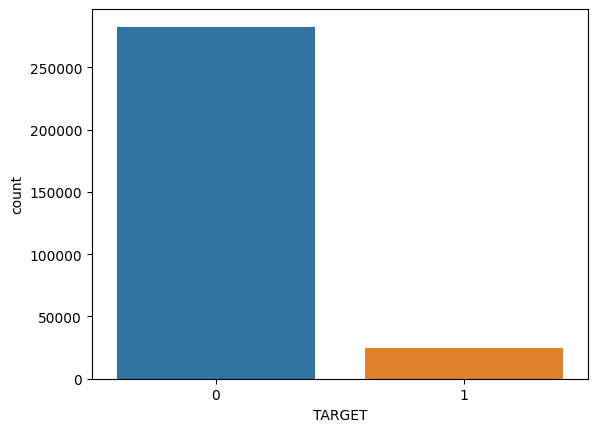

In [ ]:
if analysis_mode:
  sns.countplot(data=df_train, x='TARGET')

Классы несбалансированы, необходимо использовать метрику ROC-AUC

Проверим уникальные значения для категориальных признаков

In [ ]:
if analysis_mode:
  print('df_train:')
  check_unique_object_type_values(df_train)
  print('\ndf_test:')
  check_unique_object_type_values(df_test)

df_train:
check_unique_object_type_values: Unique values for object type features:
NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']
CODE_GENDER ['M' 'F' 'XNA']
FLAG_OWN_CAR ['N' 'Y']
FLAG_OWN_REALTY ['Y' 'N']
NAME_TYPE_SUITE ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' '

У некоторых признаков встречается значение XNA, которое скорее всего подразумевает пропущенное значение. Заменим его на np.nan

In [ ]:
if analysis_mode:
  df_train = df_train.replace('XNA', np.nan)

In [ ]:
if analysis_mode:
  df_test = df_test.replace('XNA', np.nan)

Проверим пропущенные значения

In [ ]:
if analysis_mode:
  print(get_missing_values_table(df_train).head(30))

                          count_missing_values  percentage_missing_values
COMMONAREA_AVG                          214865                  69.872297
COMMONAREA_MEDI                         214865                  69.872297
COMMONAREA_MODE                         214865                  69.872297
NONLIVINGAPARTMENTS_MEDI                213514                  69.432963
NONLIVINGAPARTMENTS_AVG                 213514                  69.432963
NONLIVINGAPARTMENTS_MODE                213514                  69.432963
FONDKAPREMONT_MODE                      210295                  68.386172
LIVINGAPARTMENTS_AVG                    210199                  68.354953
LIVINGAPARTMENTS_MEDI                   210199                  68.354953
LIVINGAPARTMENTS_MODE                   210199                  68.354953
FLOORSMIN_MEDI                          208642                  67.848630
FLOORSMIN_AVG                           208642                  67.848630
FLOORSMIN_MODE                        

Очень много признаков с большим процентом пропущенных значений.

Проверим наличие выбросов

The feature CNT_CHILDREN has the anomaly values:


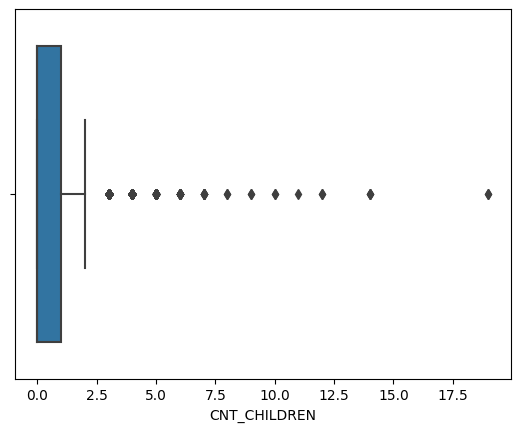

The feature AMT_INCOME_TOTAL has the anomaly values:


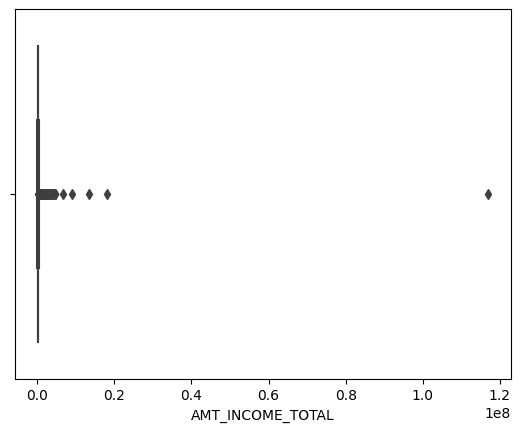

The feature AMT_CREDIT has the anomaly values:


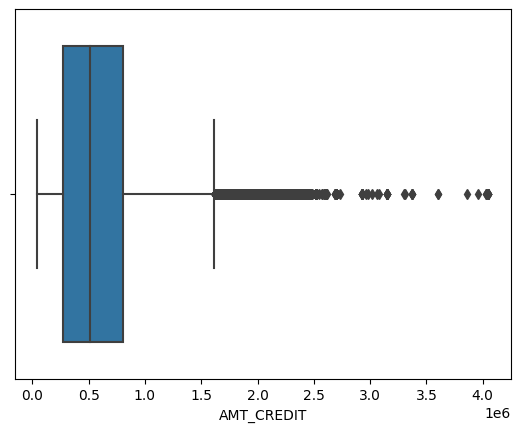

The feature AMT_ANNUITY has the anomaly values:


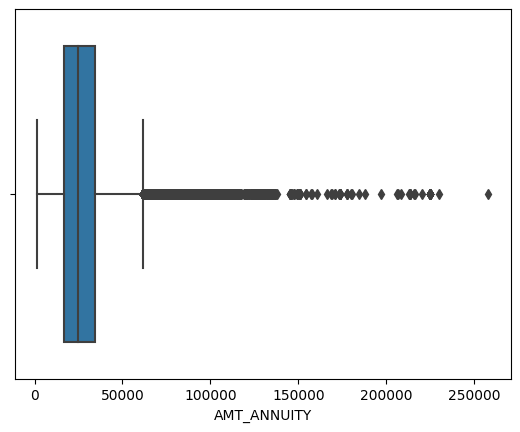

The feature AMT_GOODS_PRICE has the anomaly values:


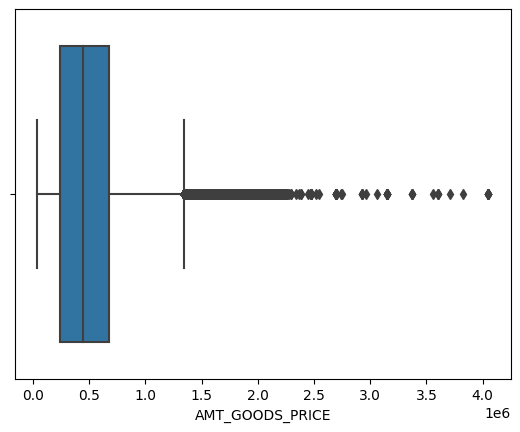

The feature DAYS_EMPLOYED has the anomaly values:


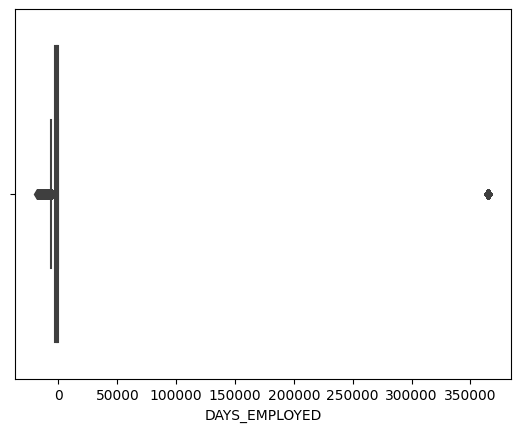

The feature DAYS_REGISTRATION has the anomaly values:


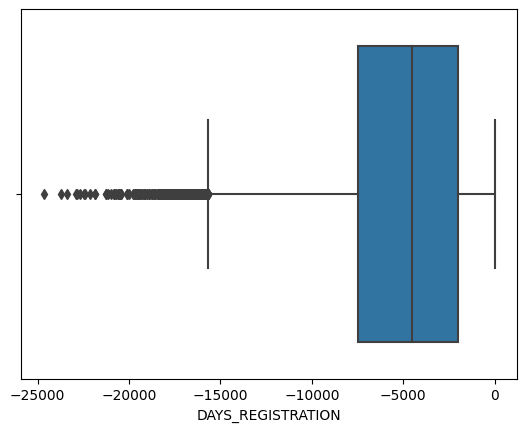

The feature OWN_CAR_AGE has the anomaly values:


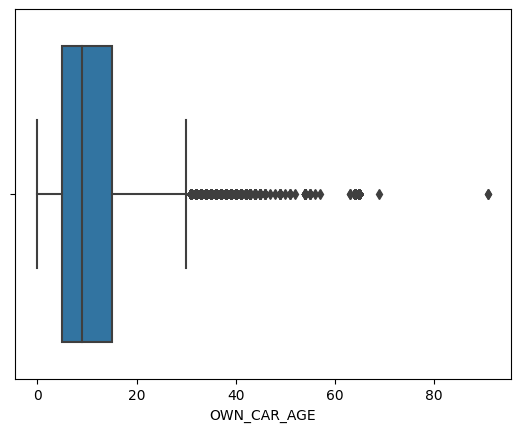

The feature CNT_FAM_MEMBERS has the anomaly values:


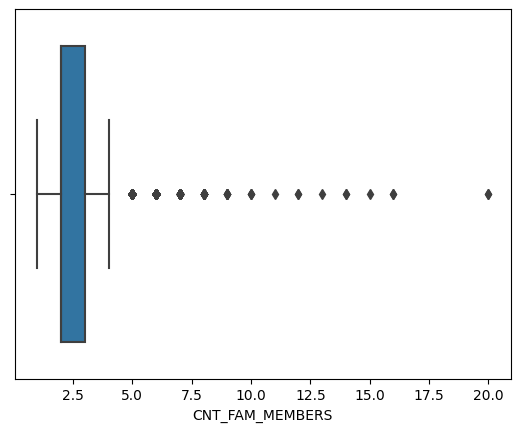

The feature REGION_RATING_CLIENT has the anomaly values:


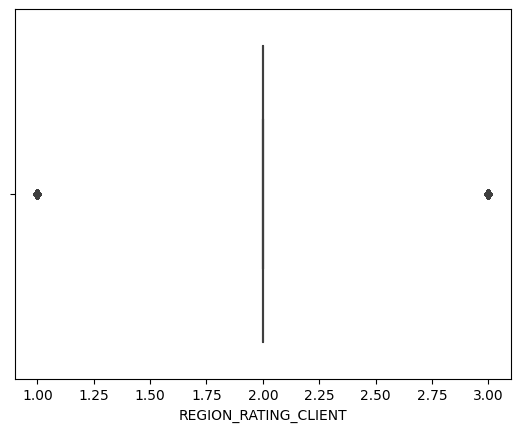

The feature REGION_RATING_CLIENT_W_CITY has the anomaly values:


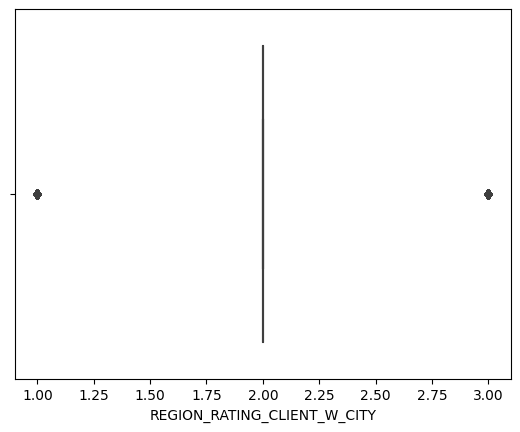

The feature APARTMENTS_AVG has the anomaly values:


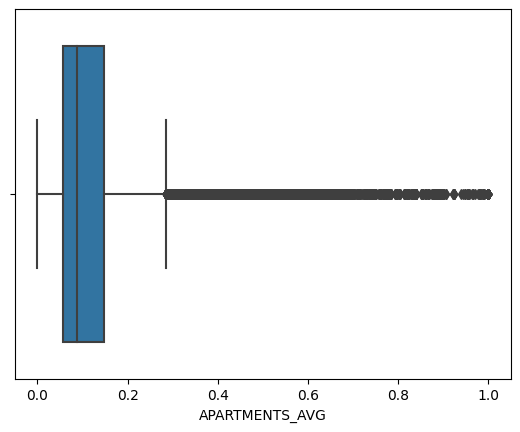

The feature BASEMENTAREA_AVG has the anomaly values:


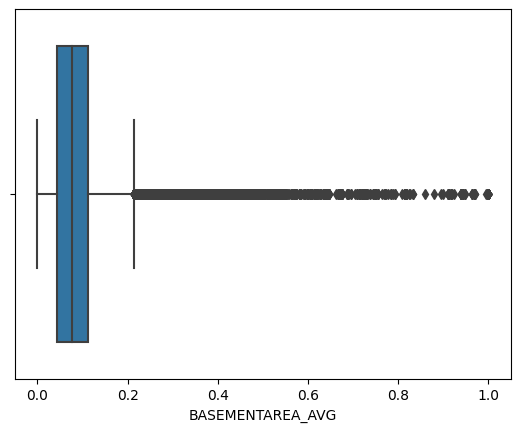

The feature YEARS_BEGINEXPLUATATION_AVG has the anomaly values:


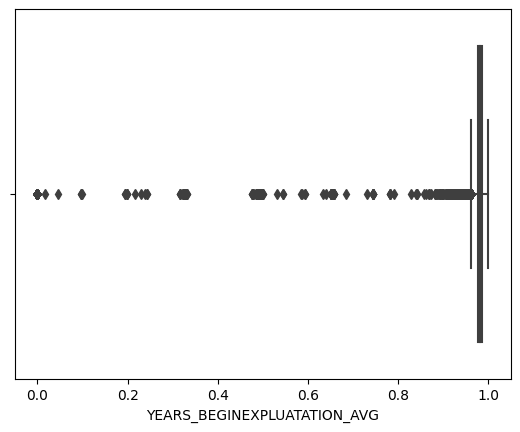

The feature YEARS_BUILD_AVG has the anomaly values:


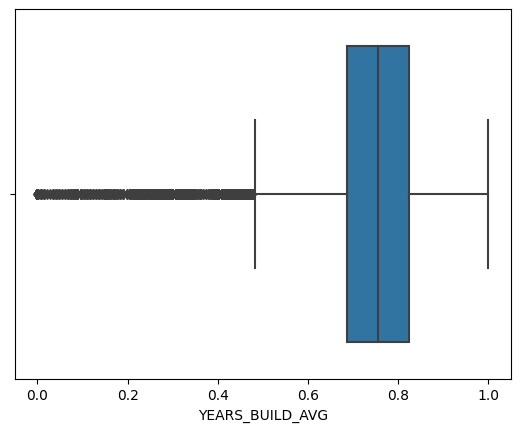

The feature COMMONAREA_AVG has the anomaly values:


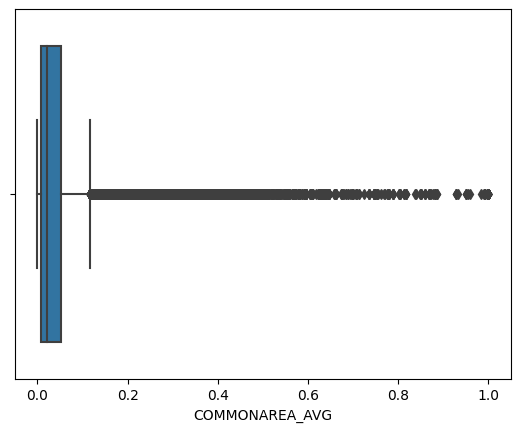

The feature ELEVATORS_AVG has the anomaly values:


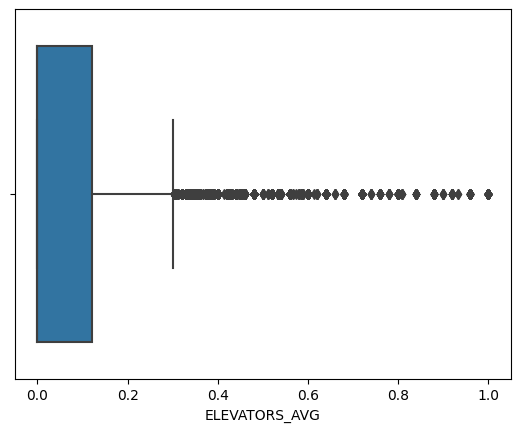

The feature ENTRANCES_AVG has the anomaly values:


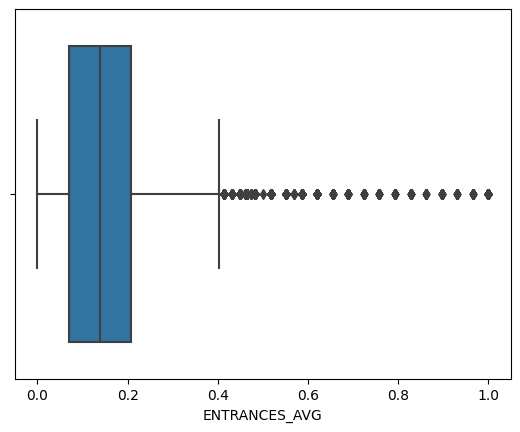

The feature FLOORSMAX_AVG has the anomaly values:


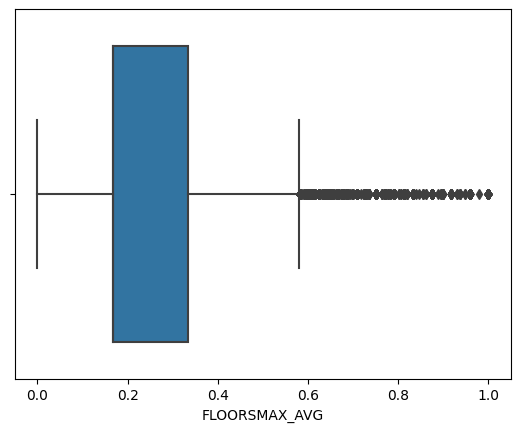

The feature LANDAREA_AVG has the anomaly values:


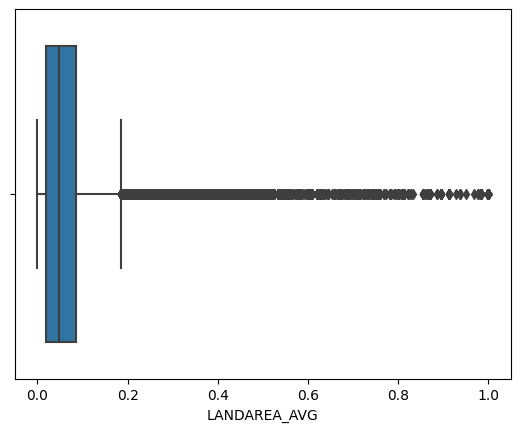

The feature LIVINGAPARTMENTS_AVG has the anomaly values:


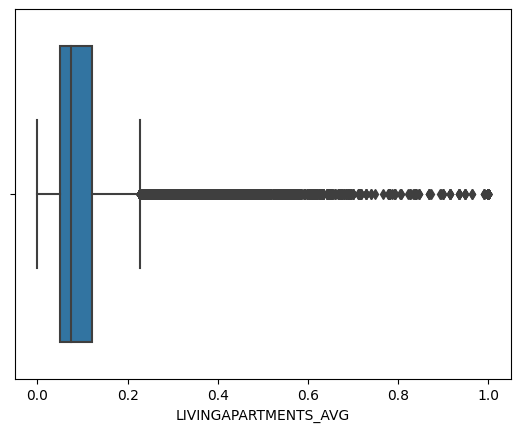

The feature LIVINGAREA_AVG has the anomaly values:


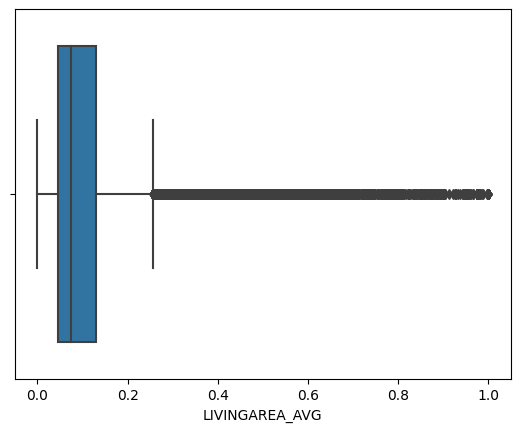

The feature NONLIVINGAPARTMENTS_AVG has the anomaly values:


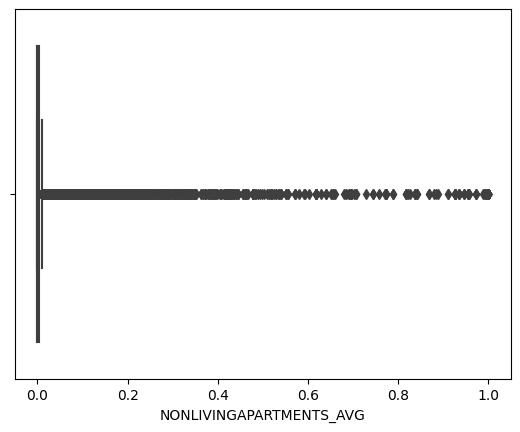

The feature NONLIVINGAREA_AVG has the anomaly values:


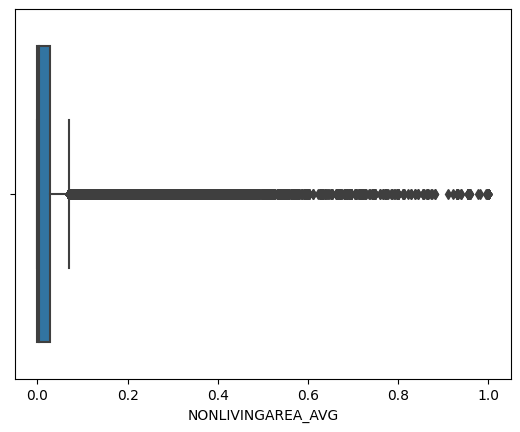

The feature APARTMENTS_MODE has the anomaly values:


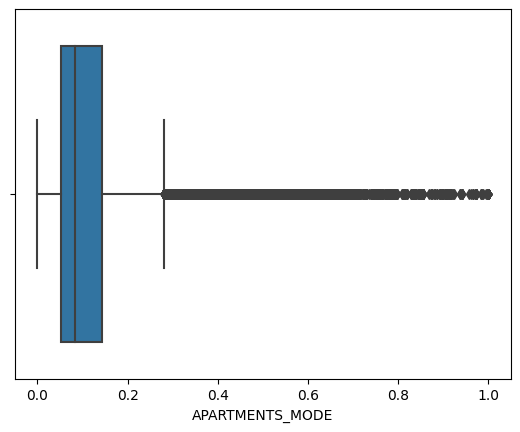

The feature BASEMENTAREA_MODE has the anomaly values:


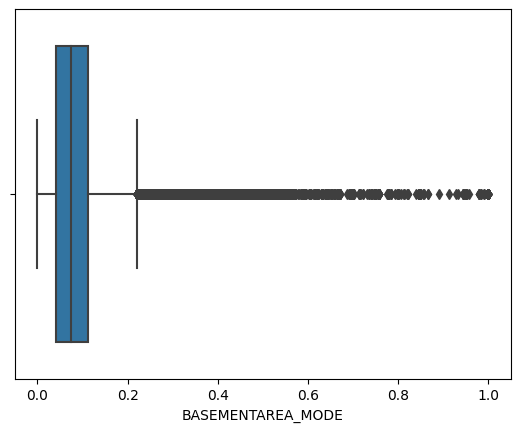

The feature YEARS_BEGINEXPLUATATION_MODE has the anomaly values:


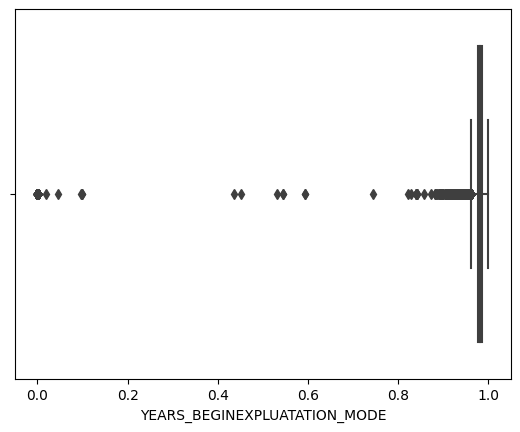

The feature YEARS_BUILD_MODE has the anomaly values:


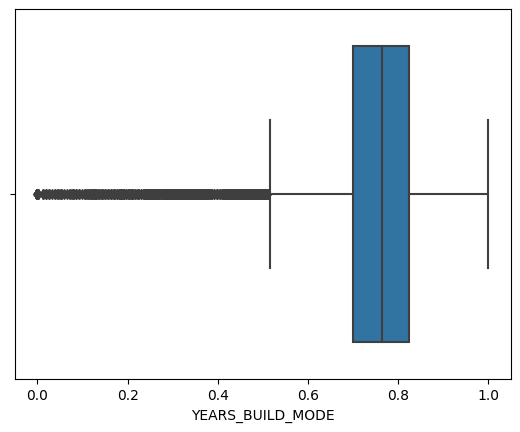

The feature COMMONAREA_MODE has the anomaly values:


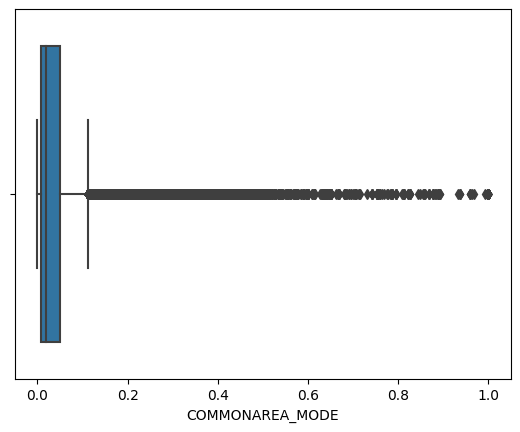

The feature ELEVATORS_MODE has the anomaly values:


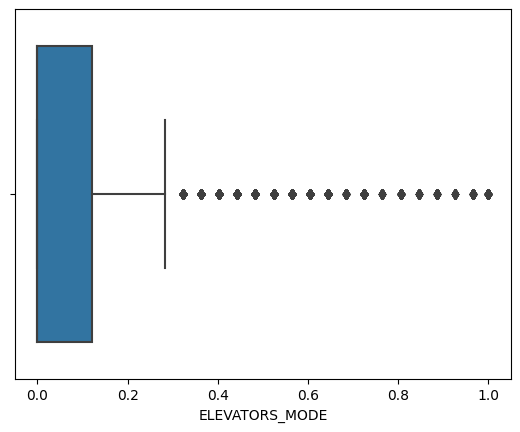

The feature ENTRANCES_MODE has the anomaly values:


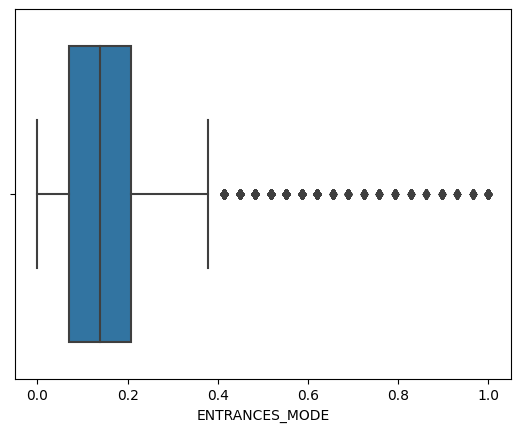

The feature FLOORSMAX_MODE has the anomaly values:


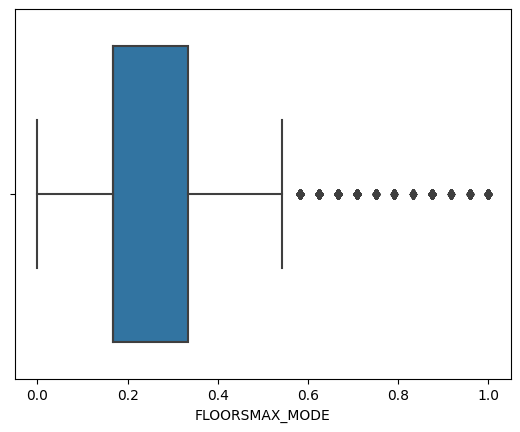

The feature LANDAREA_MODE has the anomaly values:


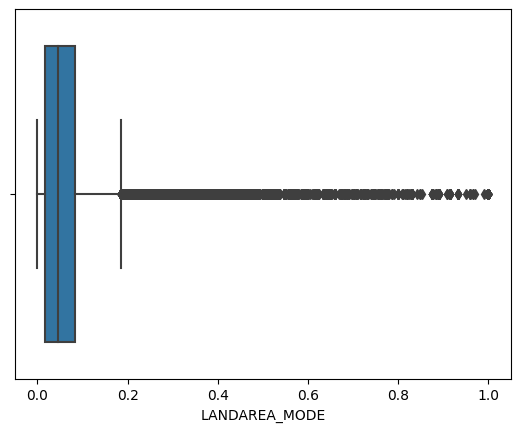

The feature LIVINGAPARTMENTS_MODE has the anomaly values:


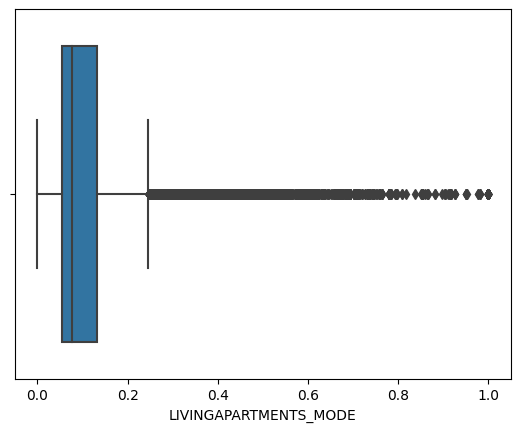

The feature LIVINGAREA_MODE has the anomaly values:


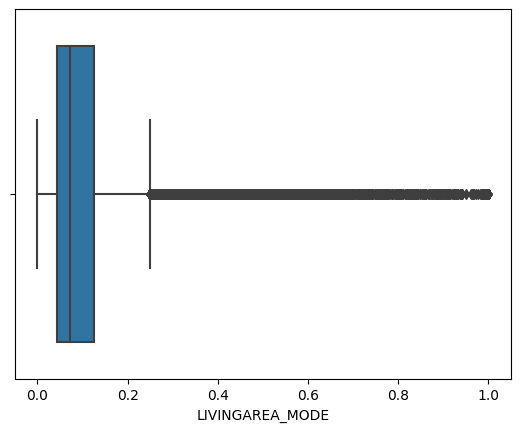

The feature NONLIVINGAPARTMENTS_MODE has the anomaly values:


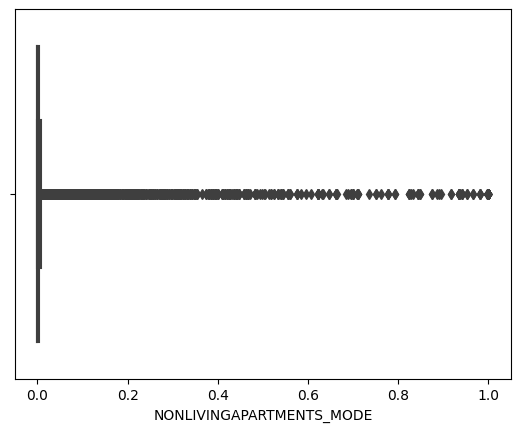

The feature NONLIVINGAREA_MODE has the anomaly values:


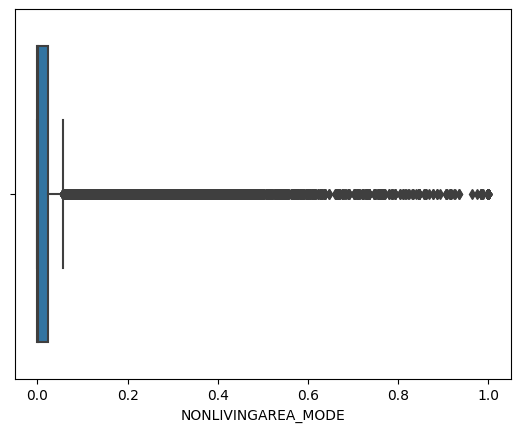

The feature APARTMENTS_MEDI has the anomaly values:


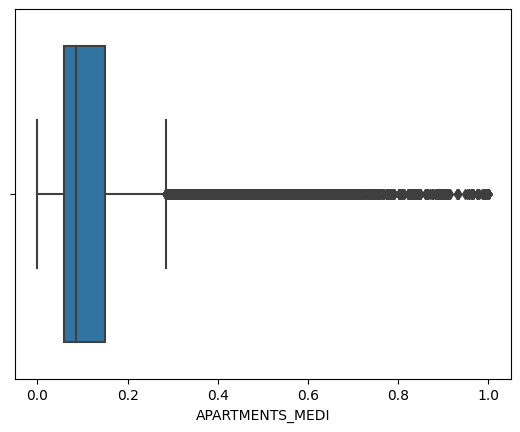

The feature BASEMENTAREA_MEDI has the anomaly values:


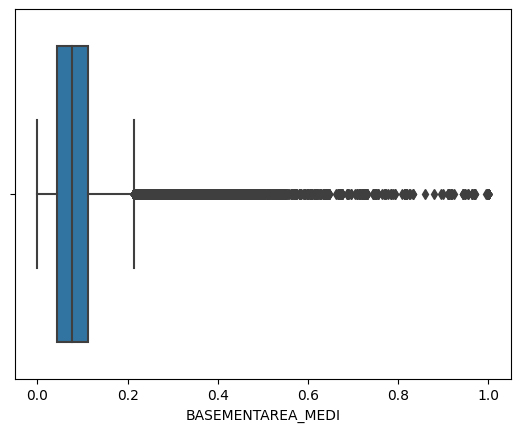

The feature YEARS_BEGINEXPLUATATION_MEDI has the anomaly values:


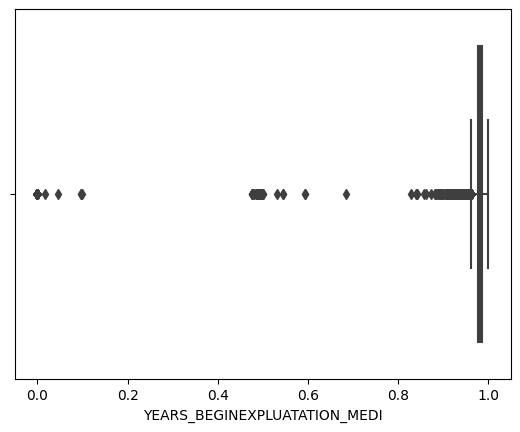

The feature YEARS_BUILD_MEDI has the anomaly values:


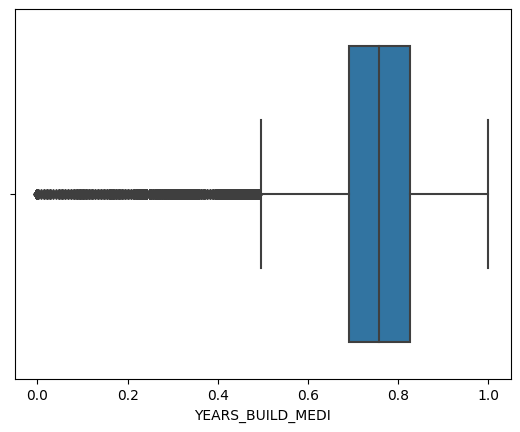

The feature COMMONAREA_MEDI has the anomaly values:


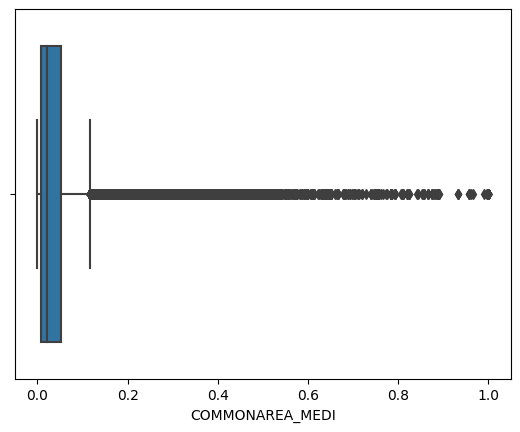

The feature ELEVATORS_MEDI has the anomaly values:


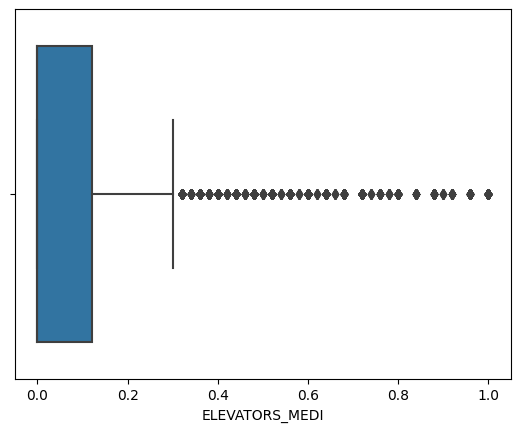

The feature ENTRANCES_MEDI has the anomaly values:


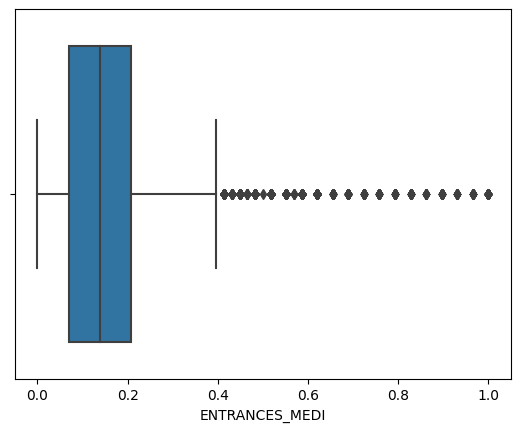

The feature FLOORSMAX_MEDI has the anomaly values:


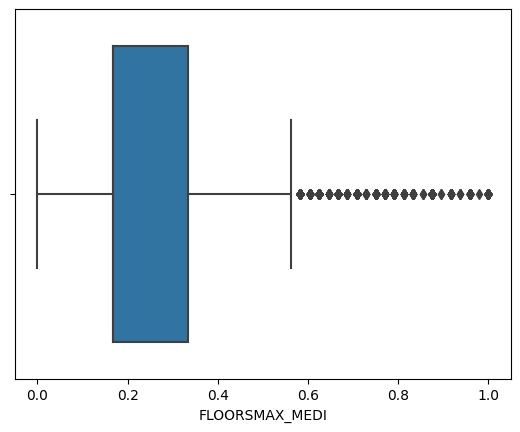

The feature LANDAREA_MEDI has the anomaly values:


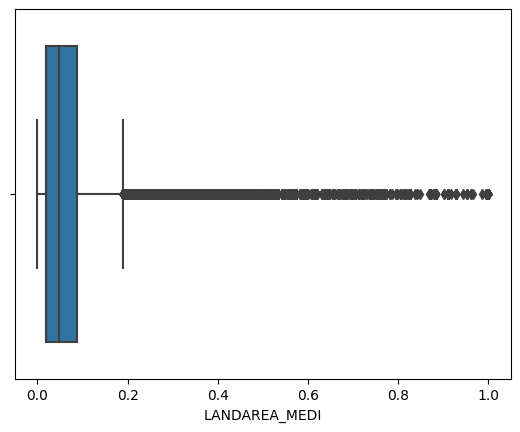

The feature LIVINGAPARTMENTS_MEDI has the anomaly values:


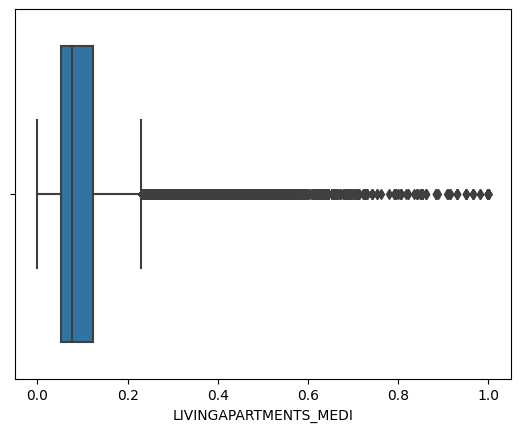

The feature LIVINGAREA_MEDI has the anomaly values:


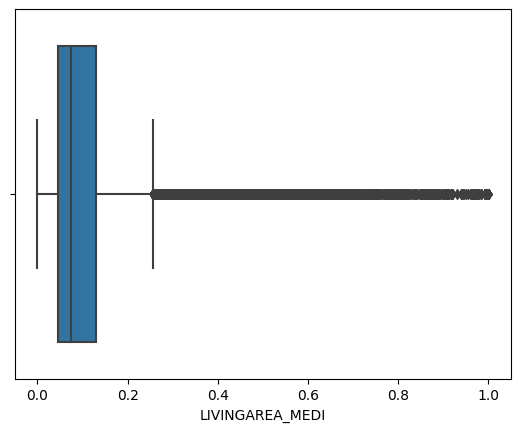

The feature NONLIVINGAPARTMENTS_MEDI has the anomaly values:


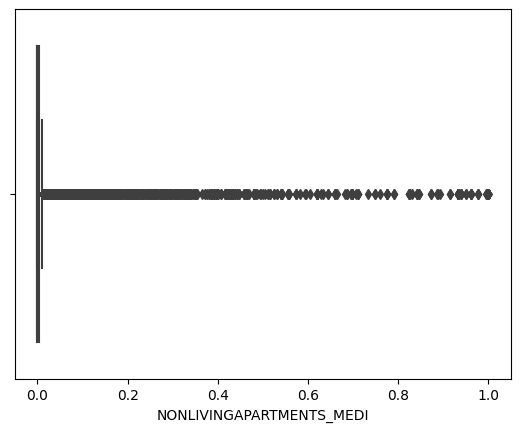

The feature NONLIVINGAREA_MEDI has the anomaly values:


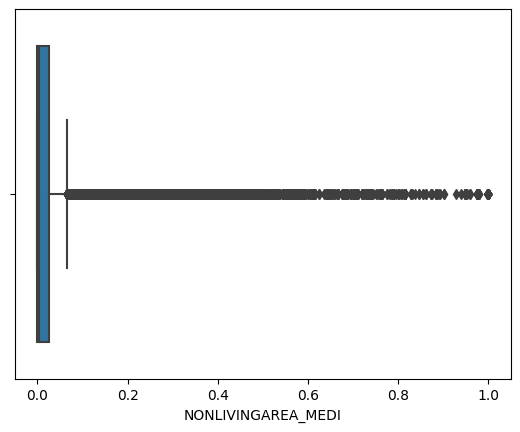

The feature TOTALAREA_MODE has the anomaly values:


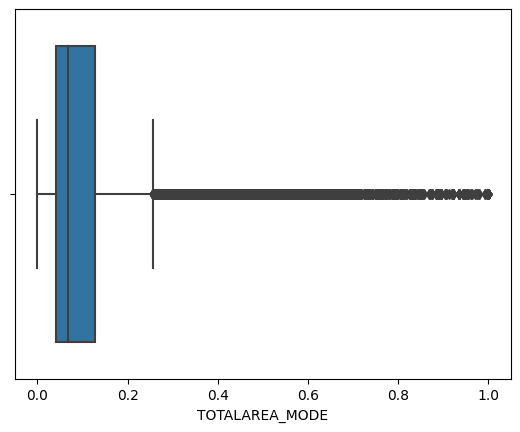

The feature OBS_30_CNT_SOCIAL_CIRCLE has the anomaly values:


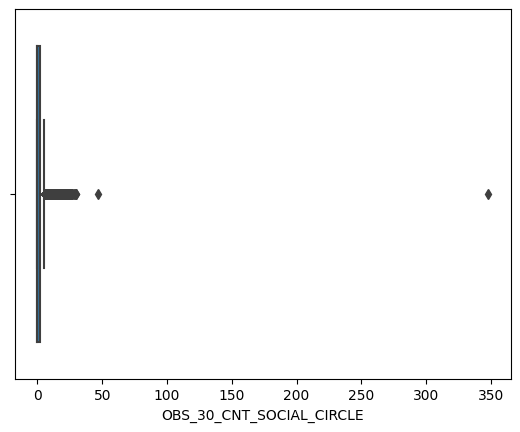

The feature DEF_30_CNT_SOCIAL_CIRCLE has the anomaly values:


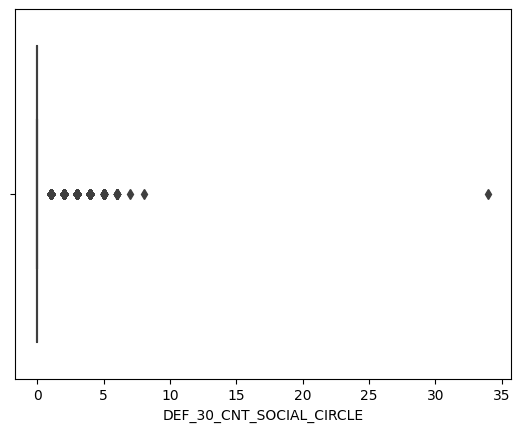

The feature OBS_60_CNT_SOCIAL_CIRCLE has the anomaly values:


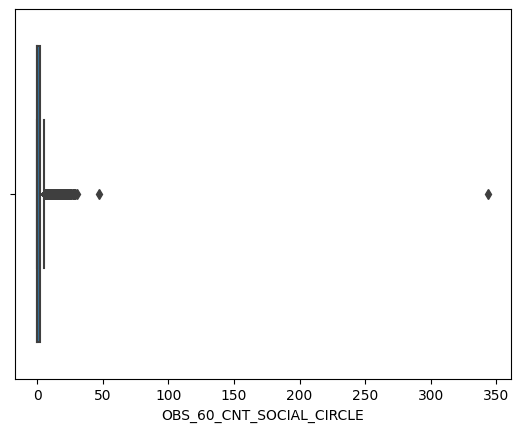

The feature DEF_60_CNT_SOCIAL_CIRCLE has the anomaly values:


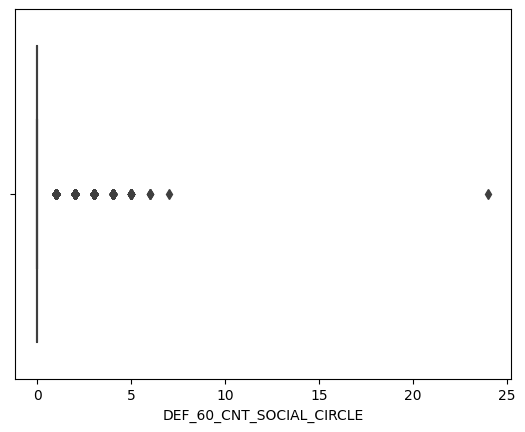

The feature AMT_REQ_CREDIT_BUREAU_HOUR has the anomaly values:


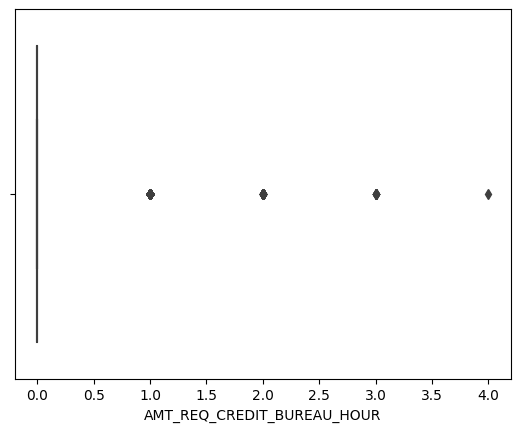

The feature AMT_REQ_CREDIT_BUREAU_DAY has the anomaly values:


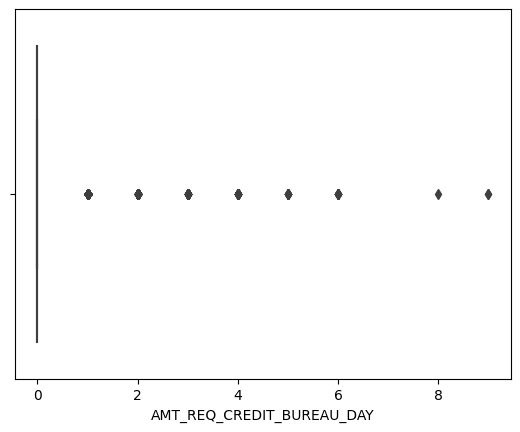

The feature AMT_REQ_CREDIT_BUREAU_WEEK has the anomaly values:


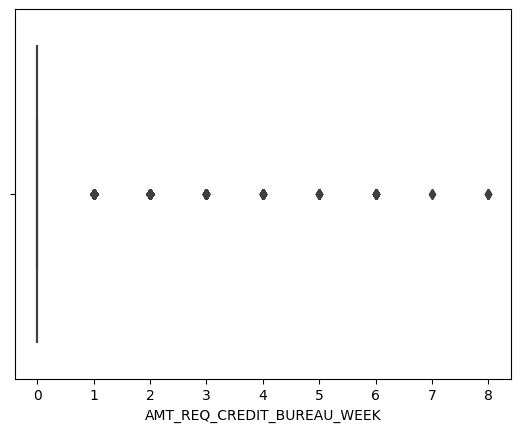

The feature AMT_REQ_CREDIT_BUREAU_MON has the anomaly values:


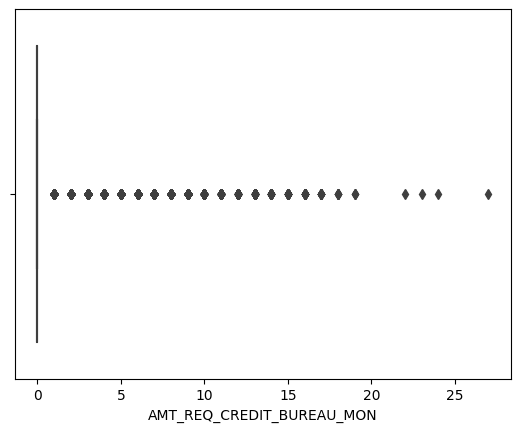

The feature AMT_REQ_CREDIT_BUREAU_QRT has the anomaly values:


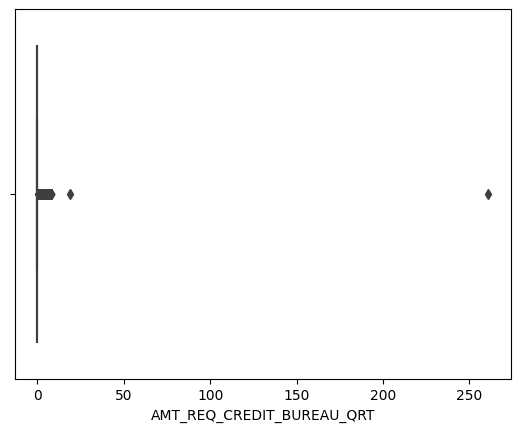

The feature AMT_REQ_CREDIT_BUREAU_YEAR has the anomaly values:


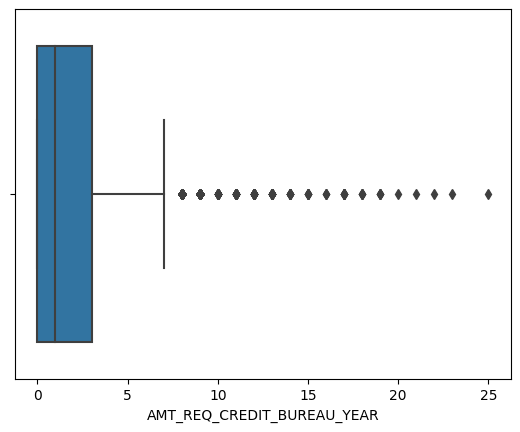

In [ ]:
if analysis_mode:
  list_anomaly = check_potential_anomaly_values(df_train, target='TARGET')

In [ ]:
if analysis_mode:
  print(sorted(df_train['DAYS_EMPLOYED'].unique())[-5:])

[-3, -2, -1, 0, 365243]


У признака DAYS_EMPLOYED наблюдается аномальное значение 365243, вероятно это ошибочное значение, поэтому заменим его на np.nan

In [ ]:
if analysis_mode:
  df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, np.nan)

In [ ]:
if analysis_mode:
  print(df_train['REGION_RATING_CLIENT'].unique())

[2 1 3]


In [ ]:
if analysis_mode:
  print(df_train['REGION_RATING_CLIENT_W_CITY'].unique())

[2 1 3]


Выполним label encoding для категориальных признаков

In [ ]:
if analysis_mode:
  df_train, label_encoders = perform_label_encoding(df_train)

perform_label_encoding: The following features has been transformed using LabelEncoder:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


Проверим корреляцию между не таргетными признаками

In [ ]:
if analysis_mode:
  list_h_c = get_list_highly_correlated_features(df_train, correlation_criterion=0.7, print_information=True)

Корреляция = 0.7701. Признаки: AMT_ANNUITY, AMT_CREDIT
Корреляция = 0.9870. Признаки: AMT_GOODS_PRICE, AMT_CREDIT
Корреляция = 0.7751. Признаки: AMT_GOODS_PRICE, AMT_ANNUITY
Корреляция = 0.8792. Признаки: CNT_FAM_MEMBERS, CNT_CHILDREN
Корреляция = 0.9508. Признаки: REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT
Корреляция = 0.8606. Признаки: LIVE_REGION_NOT_WORK_REGION, REG_REGION_NOT_WORK_REGION
Корреляция = 0.8256. Признаки: LIVE_CITY_NOT_WORK_CITY, REG_CITY_NOT_WORK_CITY
Корреляция = 0.8370. Признаки: ELEVATORS_AVG, APARTMENTS_AVG
Корреляция = 0.7424. Признаки: FLOORSMIN_AVG, FLOORSMAX_AVG
Корреляция = 0.9440. Признаки: LIVINGAPARTMENTS_AVG, APARTMENTS_AVG
Корреляция = 0.8118. Признаки: LIVINGAPARTMENTS_AVG, ELEVATORS_AVG
Корреляция = 0.9136. Признаки: LIVINGAREA_AVG, APARTMENTS_AVG
Корреляция = 0.8678. Признаки: LIVINGAREA_AVG, ELEVATORS_AVG
Корреляция = 0.8808. Признаки: LIVINGAREA_AVG, LIVINGAPARTMENTS_AVG
Корреляция = 0.9733. Признаки: APARTMENTS_MODE, APARTMENTS_AVG
Корреляц

Очень много высоко скореллированных между собой признаков. Удалим по одному из признаков с корреляцией выше 0.97.

In [ ]:
if analysis_mode:
  df_train = remove_higly_correlated_features(df_train, target='TARGET', correlation_criterion=0.97, print_information=True)

Корреляция = 0.9870. Признаки: AMT_GOODS_PRICE, AMT_CREDIT
Корреляция = 0.9733. Признаки: APARTMENTS_MODE, APARTMENTS_AVG
Корреляция = 0.9735. Признаки: BASEMENTAREA_MODE, BASEMENTAREA_AVG
Корреляция = 0.9719. Признаки: YEARS_BEGINEXPLUATATION_MODE, YEARS_BEGINEXPLUATATION_AVG
Корреляция = 0.9894. Признаки: YEARS_BUILD_MODE, YEARS_BUILD_AVG
Корреляция = 0.9771. Признаки: COMMONAREA_MODE, COMMONAREA_AVG
Корреляция = 0.9788. Признаки: ELEVATORS_MODE, ELEVATORS_AVG
Корреляция = 0.9777. Признаки: ENTRANCES_MODE, ENTRANCES_AVG
Корреляция = 0.9857. Признаки: FLOORSMAX_MODE, FLOORSMAX_AVG
Корреляция = 0.9859. Признаки: FLOORSMIN_MODE, FLOORSMIN_AVG
Корреляция = 0.9737. Признаки: LANDAREA_MODE, LANDAREA_AVG
Корреляция = 0.9701. Признаки: LIVINGAPARTMENTS_MODE, LIVINGAPARTMENTS_AVG
Корреляция = 0.9720. Признаки: LIVINGAREA_MODE, LIVINGAREA_AVG
Корреляция = 0.9951. Признаки: APARTMENTS_MEDI, APARTMENTS_AVG
Корреляция = 0.9772. Признаки: APARTMENTS_MEDI, APARTMENTS_MODE
Корреляция = 0.9943. Призн

Посмотрим корреляцию оставшихся признаков с целевым

In [ ]:
if analysis_mode:
  correlations = df_train.corr()['TARGET'].sort_values()
  print('Признаки с высокой корреляцией с целевым признаком:')
  print(correlations.head(10))
  print(correlations.tail(10))

Признаки с высокой корреляцией с целевым признаком:
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
FLOORSMIN_AVG                -0.033614
LIVINGAREA_AVG               -0.032997
TOTALAREA_MODE               -0.032596
NAME_CONTRACT_TYPE           -0.030896
Name: TARGET, dtype: float64
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER                    0.054692
NAME_EDUCATION_TYPE            0.054699
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


Некоторые признаки, с которыми корреляция целевого признака высока имеют большой проент пропусков. Например EXT_SOURCE_1 - 56% пропусков. Учитывая его высокую корреляцию с таргетом стоит сравнить вариант с удалением и сохранением признаков с большим числом пропусков.

In [ ]:
if analysis_mode:
  df_train = reduce_data_size(df_train)

Занимаемая память до оптимизации: 220.54 MB
Занимаемая память после оптимизации: 41.94 MB


### Альтернативы обработки пропусков

Будем использовать LightGBM, так как во-первых он работает с необработанными пропусками, во-вторых на основании проведенных анализов остальными участниками команды, он показывает лучшие результаты на данном датасете.

1. Оставим пропуски необработанными.

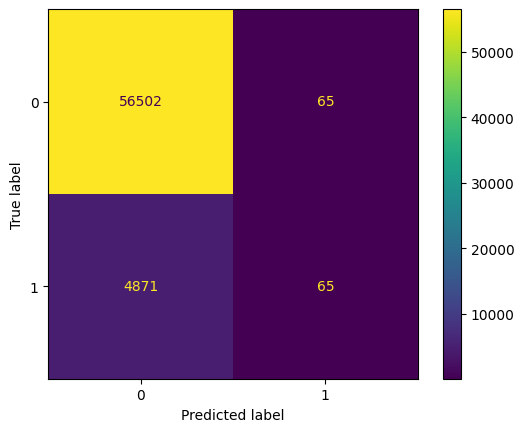

ROC-AUC
TRAIN:  -- 0.7981035861009462
VALID:  -- 0.7508099573205871


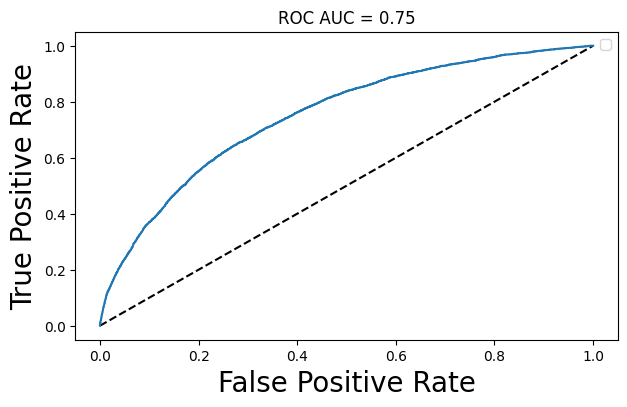

In [ ]:
if analysis_mode:
  X = df_train.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_train['TARGET']
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model = lgb.LGBMClassifier()
  model.fit(X_train, y_train)

  show_confusion_matrix(model, X_valid, y_valid)
  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

2. Удалим признаки с высоким процентом пропусков

In [ ]:
if analysis_mode:
  X = remove_features_with_missing_values(X, 40)


remove_features_with_missing_values: The following features has more than 40% missing values and have been removed:
['COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_AVG', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_AVG', 'APARTMENTS_AVG', 'ENTRANCES_AVG', 'LIVINGAREA_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE']


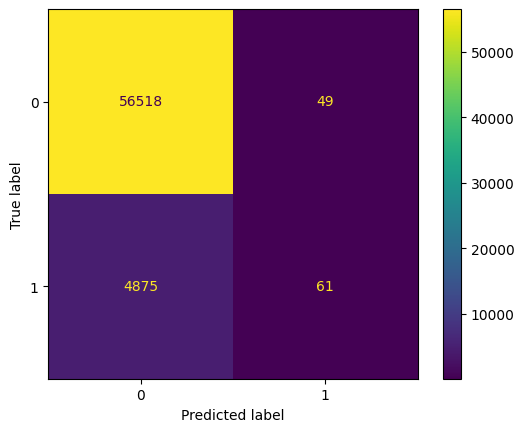

ROC-AUC
TRAIN:  -- 0.790275359304333
VALID:  -- 0.7458460534128302


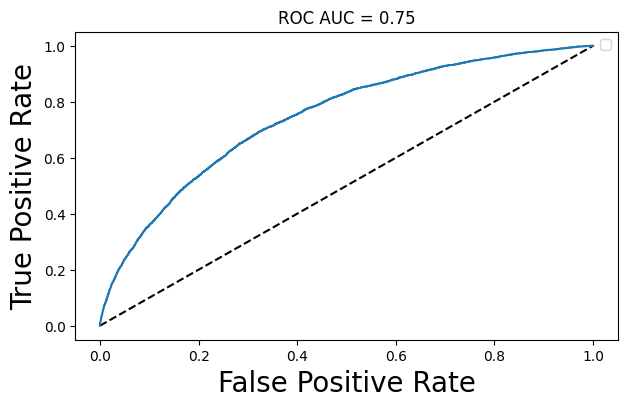

In [ ]:
if analysis_mode:
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model = lgb.LGBMClassifier()
  model.fit(X_train, y_train)

  show_confusion_matrix(model, X_valid, y_valid)
  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

3. Заполним оставшие после удаления пропуски (менее 30% пропусков) медианой

In [ ]:
if analysis_mode:
  X = fill_missing_values(X)


fill_missing_values: The missing values for the following columns has been filled:
['EXT_SOURCE_3', 'DAYS_EMPLOYED', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']


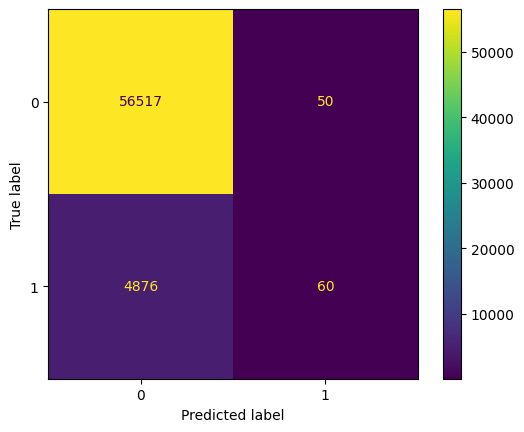

ROC-AUC
TRAIN:  -- 0.7880104951623421
VALID:  -- 0.74521386251309


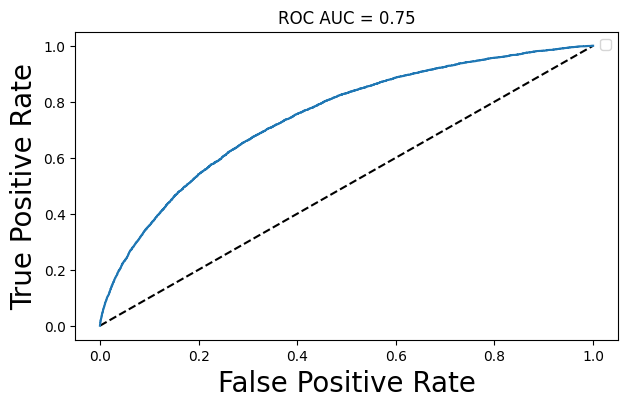

In [ ]:
if analysis_mode:
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model = lgb.LGBMClassifier()
  model.fit(X_train, y_train)

  show_confusion_matrix(model, X_valid, y_valid)
  roc_auc = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

Вариант с необработанными пропусками показывает лучший результат. В дальнейшем будем использовать именно его.

In [ ]:
if analysis_mode:
  del df_train
  del df_test

### Функция предобработки

Составим функцию для предобработки таблиц application_train и application_test

In [ ]:
def prepare_application_train_test():
  ''' Подготовим данные из application_train.csv и application_test.csv
  таблиц для использования

  Возвращаемые значения:
  df_train - данные из application_train.csv таблицы с выполненной предобработкой
  df_test - данные из application_test.csv таблицы с выполненной предобработкой
  '''
  # считываем данные
  df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/application_train.csv')
  df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/application_test.csv')

  # заменяем аномальные значения
  df_train = df_train.replace('XNA', np.nan)
  df_test = df_test.replace('XNA', np.nan)

  df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, np.nan)
  df_test['DAYS_EMPLOYED'] = df_test['DAYS_EMPLOYED'].replace(365243, np.nan)

  # выполняем кодирование категориальных признаков.
  df_train, df_test, label_encoders = perform_label_encoding(df_train, df_test)

  # сжимаем таблицы
  df_train = reduce_data_size(df_train)
  df_test = reduce_data_size(df_test)

  # удаляем признаки с корреляцией по модулю 0.97 и больше
  df_train, df_test = remove_higly_correlated_features(df_train, target='TARGET', df_test=df_test, correlation_criterion=0.97, print_information=False)

  return df_train, df_test

## df_bureau

In [20]:
if analysis_mode:
  df_bureau = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/bureau.csv')
  df_bureau_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/bureau_balance.csv')
  df_bureau = df_bureau.merge(df_bureau_balance, how='left', on='SK_ID_BUREAU')
  del df_bureau_balance

Проверим наличие подозрительных значений у категориальных признаков

In [ ]:
if analysis_mode:
  check_unique_object_type_values(df_bureau)

check_unique_object_type_values: Unique values for object type features:
CREDIT_ACTIVE ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY ['currency 1' 'currency 2' 'currency 4' 'currency 3']
CREDIT_TYPE ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']
STATUS [nan 'C' '0' 'X' '1' '2' '5' '4' '3']


Проверим пропуски

In [ ]:
if analysis_mode:
  print(get_missing_values_table(df_bureau).head(30))

                        count_missing_values  percentage_missing_values
AMT_CREDIT_MAX_OVERDUE              18130741                  72.171302
AMT_CREDIT_SUM_LIMIT                10671361                  42.478463
AMT_ANNUITY                         10495530                  41.778550
DAYS_ENDDATE_FACT                    5978831                  23.799359
AMT_CREDIT_SUM_DEBT                  4234392                  16.855438
DAYS_CREDIT_ENDDATE                  1232569                   4.906369
MONTHS_BALANCE                        942074                   3.750024
STATUS                                942074                   3.750024
AMT_CREDIT_SUM                            13                   0.000052


The feature CREDIT_DAY_OVERDUE has the anomaly values:


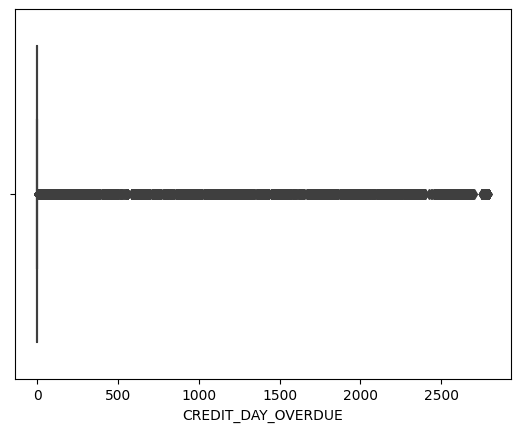

The feature DAYS_CREDIT_ENDDATE has the anomaly values:


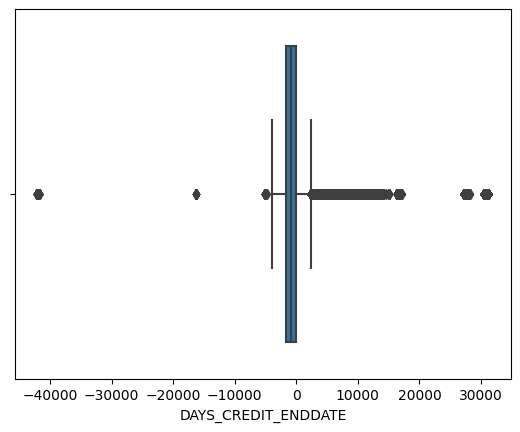

The feature DAYS_ENDDATE_FACT has the anomaly values:


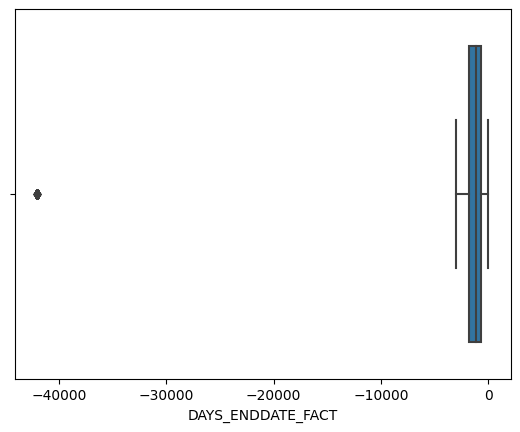

The feature AMT_CREDIT_MAX_OVERDUE has the anomaly values:


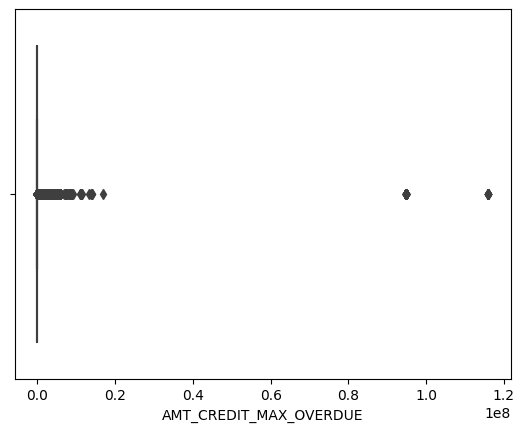

The feature CNT_CREDIT_PROLONG has the anomaly values:


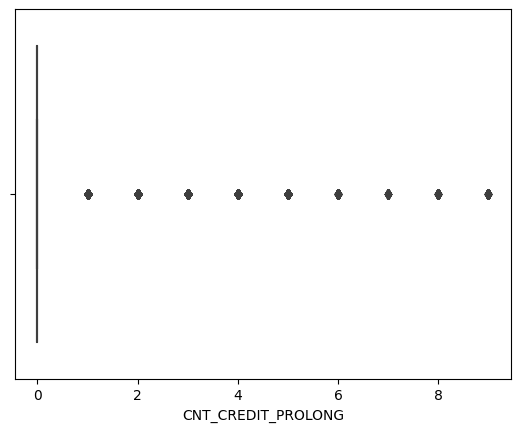

The feature AMT_CREDIT_SUM has the anomaly values:


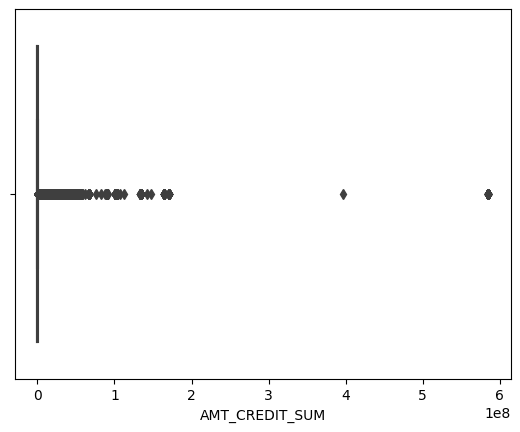

The feature AMT_CREDIT_SUM_DEBT has the anomaly values:


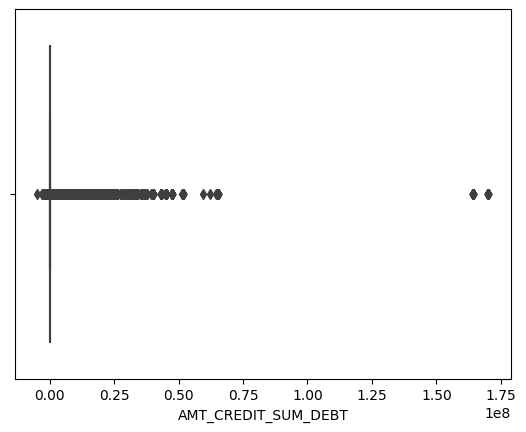

The feature AMT_CREDIT_SUM_LIMIT has the anomaly values:


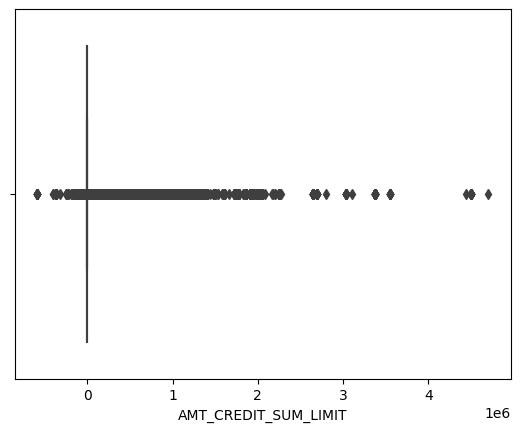

The feature AMT_CREDIT_SUM_OVERDUE has the anomaly values:


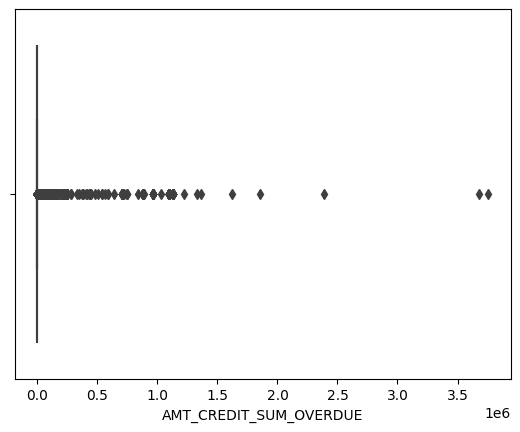

The feature DAYS_CREDIT_UPDATE has the anomaly values:


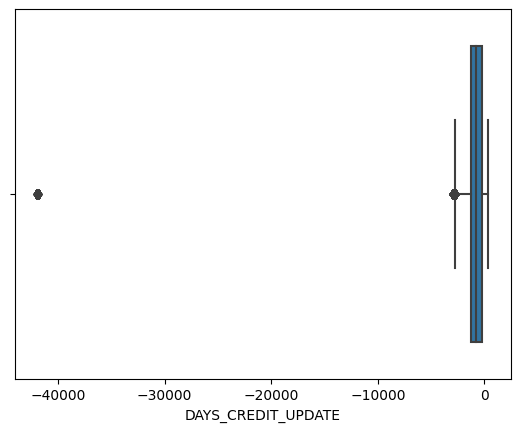

The feature AMT_ANNUITY has the anomaly values:


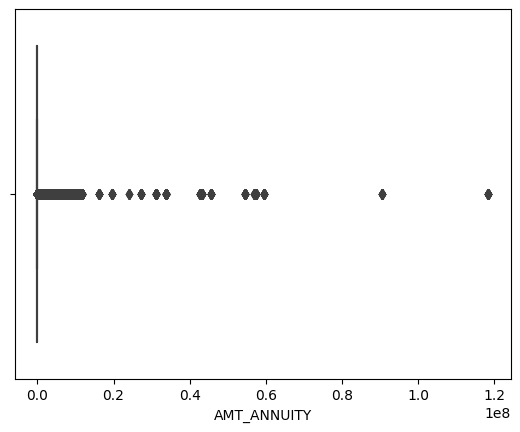

In [21]:
if analysis_mode:
  list_anomaly = check_potential_anomaly_values(df_bureau, target='TARGET')

Выполним label encoding

In [22]:
if analysis_mode:
  df_bureau, label_encoders_bureau = perform_label_encoding(df_bureau)

perform_label_encoding: The following features has been transformed using LabelEncoder:
['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'STATUS']


In [23]:
if analysis_mode:
  df_bureau = reduce_data_size(df_bureau)

Занимаемая память до оптимизации: 3833.28 MB
Занимаемая память после оптимизации: 1413.52 MB


In [24]:
if analysis_mode:
  del df_bureau

### Функция предобработки

In [ ]:
def prepare_bureau():
  ''' Подготовим данные из bureau.csv и bureau_balance.csv
  таблиц для использования

  Возвращаемые значения:
  bureau_agg - данные из считанных таблиц с выполненной предобработкой
  '''
  # считываем данные
  df_bureau = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/bureau.csv')
  df_bureau_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/bureau_balance.csv')
  # мержим к таблице bureau таблицу bureau_balance
  df_bureau = df_bureau.merge(df_bureau_balance, how='left', on='SK_ID_BUREAU')
  del df_bureau_balance

  # выполняем Label Encoding для категориальных признаков
  df_bureau, label_encoders_bureau = perform_label_encoding(df_bureau)

  # уменьшаем занимаемую таблицей память
  df_bureau = reduce_data_size(df_bureau)

  bureau_dict_agg = {'SK_ID_BUREAU':['count'],
    'CREDIT_ACTIVE': ['median'],
    'CREDIT_CURRENCY': ['median'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    'MONTHS_BALANCE': ['max', 'mean', 'sum'],
    'STATUS': ['median']
  }

  # группируем строки в таблице по SK_ID_CURR и аггрегируем значения
  # используя bureau_dict_agg
  bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(bureau_dict_agg)
  bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

  return bureau_agg

## previous_application

In [25]:
if analysis_mode:
  df_previous_application = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/previous_application.csv')

In [26]:
if analysis_mode:
  check_unique_object_type_values(df_previous_application)

check_unique_object_type_values: Unique values for object type features:
NAME_CONTRACT_TYPE ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
WEEKDAY_APPR_PROCESS_START ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
FLAG_LAST_APPL_PER_CONTRACT ['Y' 'N']
NAME_CASH_LOAN_PURPOSE ['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']
NAME_CONTRACT_STATUS ['Approved' 'Refused' 'Canceled' 'Unused offer']
NAME_PAYMENT_TYPE ['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']
CODE_REJECT_REASON ['XAP' 

In [27]:
if analysis_mode:
  df_previous_application = df_previous_application.replace('XNA', np.nan)

In [29]:
if analysis_mode:
  print(get_missing_values_table(df_previous_application, 30))

                           count_missing_values  percentage_missing_values
RATE_INTEREST_PRIMARY                   1664263                  99.643698
RATE_INTEREST_PRIVILEGED                1664263                  99.643698
NAME_PRODUCT_TYPE                       1063666                  63.684414
NAME_GOODS_CATEGORY                      950809                  56.927376
RATE_DOWN_PAYMENT                        895844                  53.636480
AMT_DOWN_PAYMENT                         895844                  53.636480
NAME_SELLER_INDUSTRY                     855720                  51.234153
NAME_TYPE_SUITE                          820405                  49.119754
NAME_CASH_LOAN_PURPOSE                   677918                  40.588691
DAYS_FIRST_DRAWING                       673065                  40.298129
DAYS_FIRST_DUE                           673065                  40.298129
DAYS_LAST_DUE_1ST_VERSION                673065                  40.298129
DAYS_LAST_DUE            

The feature AMT_ANNUITY has the anomaly values:


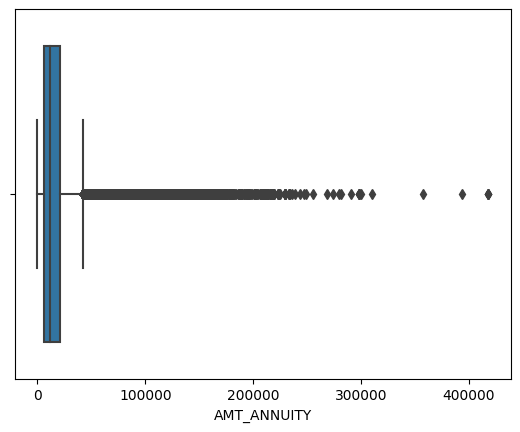

The feature AMT_APPLICATION has the anomaly values:


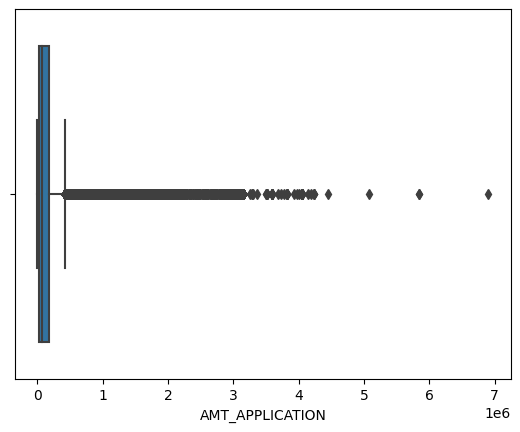

The feature AMT_CREDIT has the anomaly values:


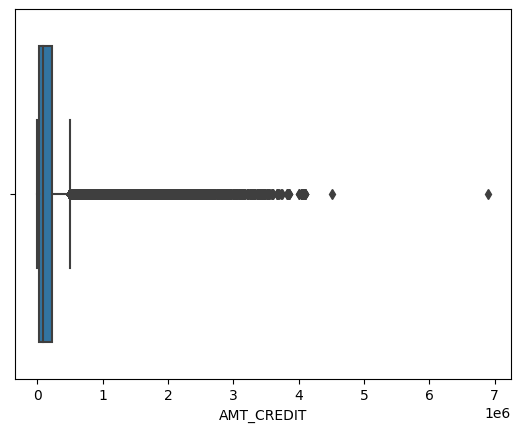

The feature AMT_DOWN_PAYMENT has the anomaly values:


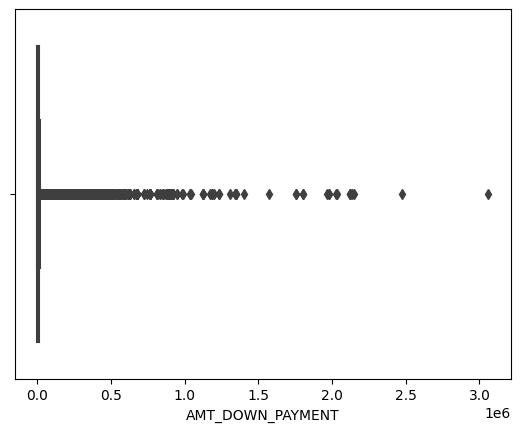

The feature AMT_GOODS_PRICE has the anomaly values:


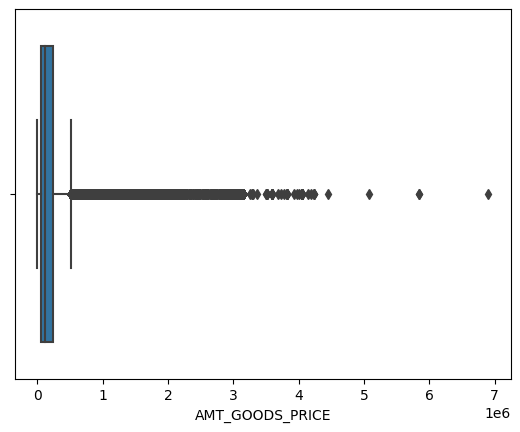

The feature RATE_DOWN_PAYMENT has the anomaly values:


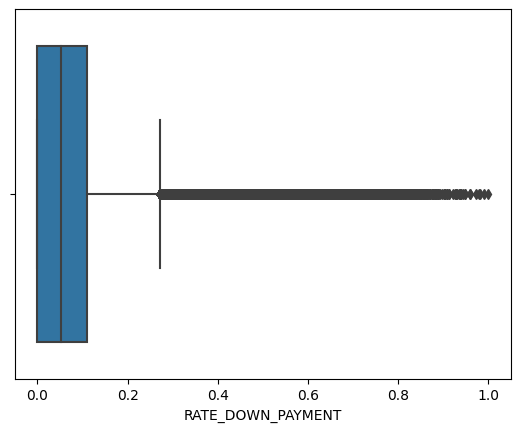

The feature RATE_INTEREST_PRIMARY has the anomaly values:


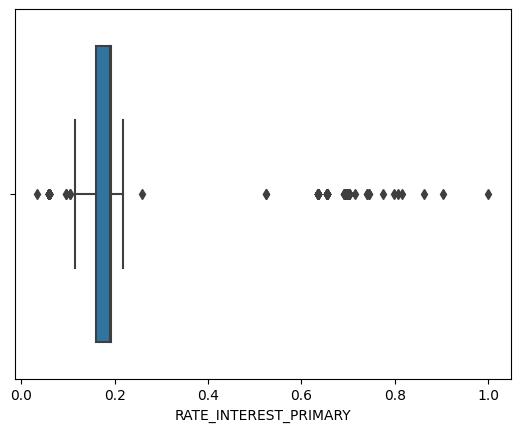

The feature SELLERPLACE_AREA has the anomaly values:


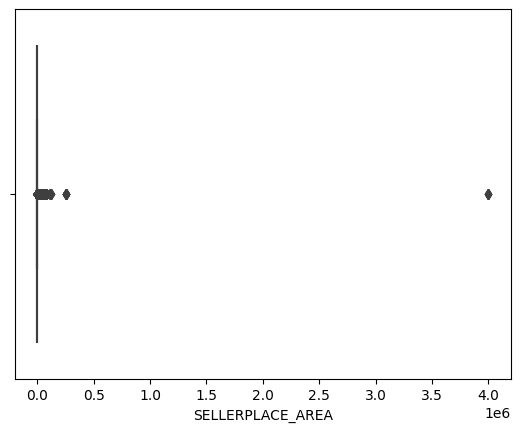

The feature CNT_PAYMENT has the anomaly values:


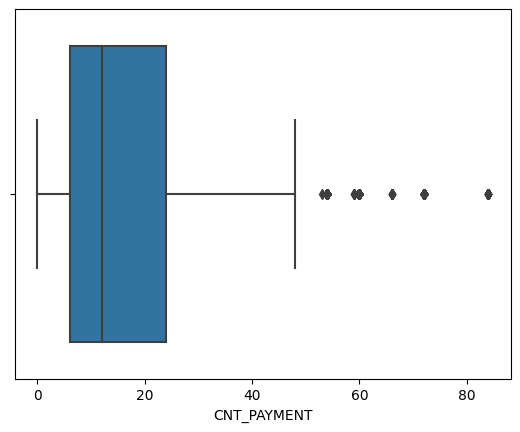

The feature DAYS_FIRST_DRAWING has the anomaly values:


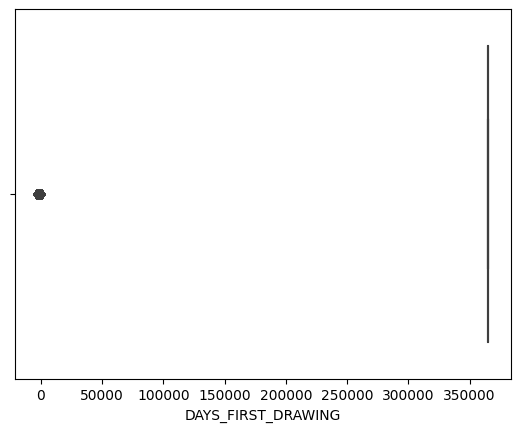

The feature DAYS_FIRST_DUE has the anomaly values:


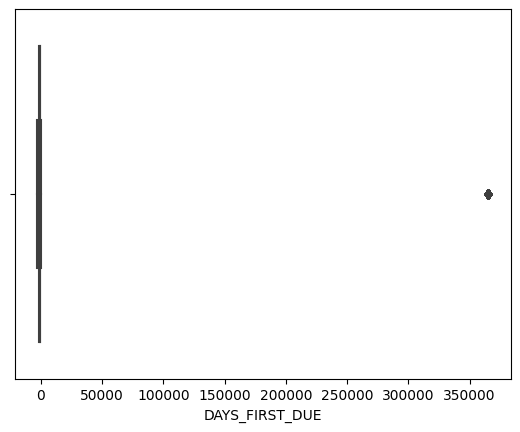

The feature DAYS_LAST_DUE_1ST_VERSION has the anomaly values:


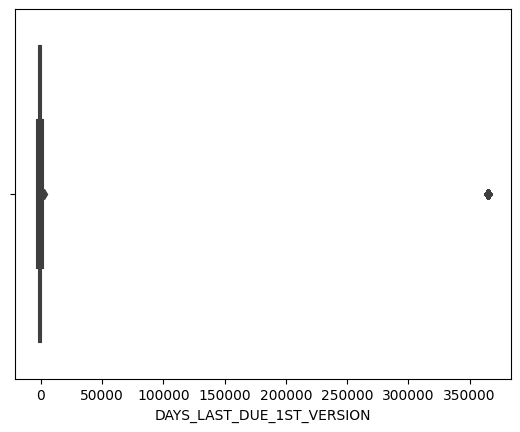

The feature DAYS_LAST_DUE has the anomaly values:


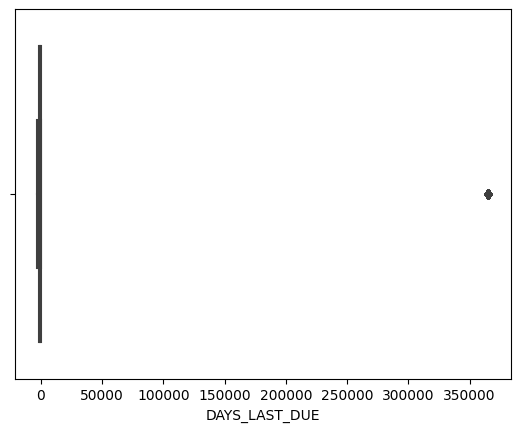

The feature DAYS_TERMINATION has the anomaly values:


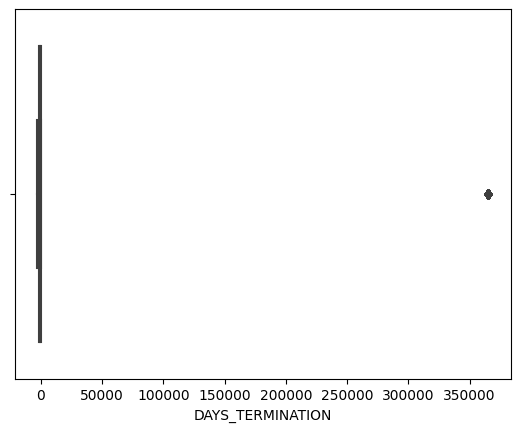

In [30]:
if analysis_mode:
  list_anomaly = check_potential_anomaly_values(df_previous_application, target='TARGET')

In [31]:
if analysis_mode:
  df_previous_application['DAYS_LAST_DUE_1ST_VERSION'] = df_previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan)
  df_previous_application['DAYS_LAST_DUE'] = df_previous_application['DAYS_LAST_DUE'].replace(365243, np.nan)
  df_previous_application['DAYS_TERMINATION'] = df_previous_application['DAYS_TERMINATION'].replace(365243, np.nan)
  df_previous_application['DAYS_FIRST_DUE'] = df_previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan)

In [32]:
if analysis_mode:
  df_previous_application, label_encoders_prev = perform_label_encoding(df_previous_application)

perform_label_encoding: The following features has been transformed using LabelEncoder:
['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']


In [33]:
if analysis_mode:
  df_previous_application = reduce_data_size(df_previous_application)

Занимаемая память до оптимизации: 471.48 MB
Занимаемая память после оптимизации: 117.87 MB


In [34]:
if analysis_mode:
  del df_previous_application

### Функция предобработки

In [ ]:
def prepare_previous_application():
  ''' Подготовим данные из previous_application.csv таблицы для использования

  Возвращаемые значения:
  prev_agg - данные из считанной таблицы с выполненной предобработкой
  '''
  # считываем данные
  df_previous_application = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/previous_application.csv')

  # заменяем аномальные значения
  df_previous_application = df_previous_application.replace('XNA', np.nan)
  df_previous_application['DAYS_LAST_DUE_1ST_VERSION'] = df_previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan)
  df_previous_application['DAYS_LAST_DUE'] = df_previous_application['DAYS_LAST_DUE'].replace(365243, np.nan)
  df_previous_application['DAYS_TERMINATION'] = df_previous_application['DAYS_TERMINATION'].replace(365243, np.nan)
  df_previous_application['DAYS_FIRST_DUE'] = df_previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan)

  # выполняем Label Encoding для категориальных признаков
  df_previous_application, label_encoders_prev = perform_label_encoding(df_previous_application)

  # уменьшаем занимаемую таблицей память
  df_previous_application = reduce_data_size(df_previous_application)

  prev_dict_agg = {'SK_ID_CURR':['count'],
    'NAME_CONTRACT_TYPE': ['median'],
    'AMT_ANNUITY': ['mean', 'max', 'sum'],
    'AMT_APPLICATION': ['mean', 'max', 'sum'],
    'AMT_CREDIT': ['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT': ['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE': ['mean', 'max', 'sum'],
    'WEEKDAY_APPR_PROCESS_START': ['median'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'FLAG_LAST_APPL_PER_CONTRACT': ['median'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
    'NAME_CASH_LOAN_PURPOSE': ['median'],
    'NAME_CONTRACT_STATUS': ['median'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'NAME_PAYMENT_TYPE': ['median'],
    'CODE_REJECT_REASON': ['median'],
    'NAME_TYPE_SUITE': ['median'],
    'NAME_CLIENT_TYPE': ['median'],
    'NAME_GOODS_CATEGORY': ['median'],
    'NAME_PORTFOLIO': ['median'],
    'NAME_PRODUCT_TYPE': ['median'],
    'CHANNEL_TYPE': ['median'],
    'SELLERPLACE_AREA': ['median'],
    'NAME_SELLER_INDUSTRY': ['median'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'NAME_YIELD_GROUP': ['min', 'max', 'sum'],
    'PRODUCT_COMBINATION': ['median'],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['min', 'max', 'mean'],
    'DAYS_TERMINATION': ['min', 'max', 'mean'],
  }

  # группируем строки в таблице по SK_ID_CURR и аггрегируем значения
  # используя prev_dict_agg
  prev_agg = df_previous_application.groupby('SK_ID_CURR').agg(prev_dict_agg)
  prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
  
  return prev_agg

## installments_payments

In [35]:
if analysis_mode:
  df_installments_payments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/installments_payments.csv')

In [36]:
if analysis_mode:
  print(get_missing_values_table(df_installments_payments).head(30))

                    count_missing_values  percentage_missing_values
DAYS_ENTRY_PAYMENT                  2905                   0.021352
AMT_PAYMENT                         2905                   0.021352


The feature NUM_INSTALMENT_VERSION has the anomaly values:


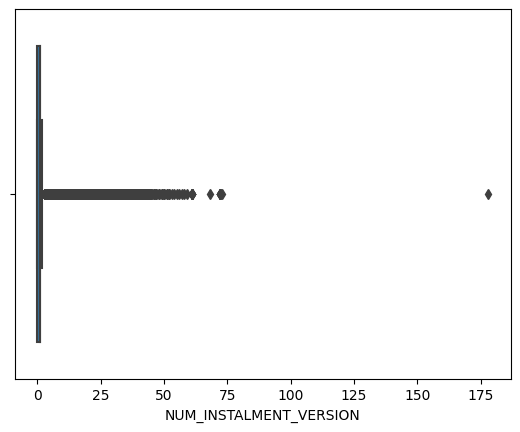

The feature NUM_INSTALMENT_NUMBER has the anomaly values:


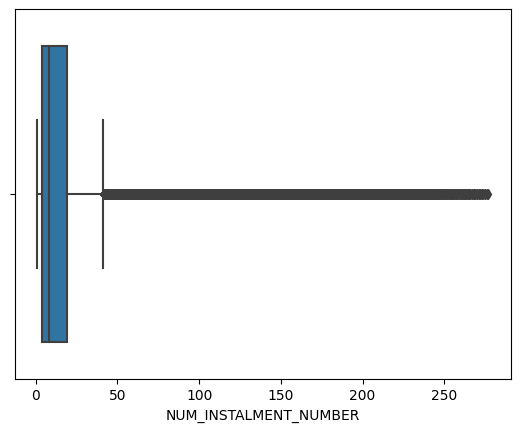

The feature AMT_INSTALMENT has the anomaly values:


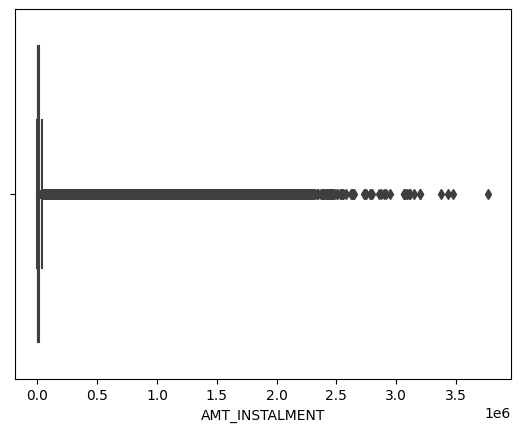

The feature AMT_PAYMENT has the anomaly values:


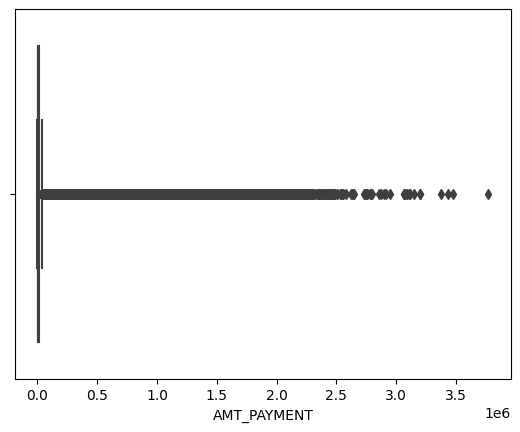

In [37]:
if analysis_mode:
  list_anomaly = check_potential_anomaly_values(df_installments_payments, target='TARGET')

In [38]:
if analysis_mode:
  df_installments_payments = reduce_data_size(df_installments_payments)

Занимаемая память до оптимизации: 830.41 MB
Занимаемая память после оптимизации: 311.40 MB


In [39]:
if analysis_mode:
  del df_installments_payments

### Функция предобработки

In [ ]:
def prepare_installments():
  ''' Подготовим данные из installments_payments.csv таблицы для использования

  Возвращаемые значения:
  inst_agg - данные из считанной таблицы с выполненной предобработкой
  '''
  # считываем данные
  df_installments_payments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/installments_payments.csv')
  # среди признаков таблицы нет категориальных

  # уменьшаем занимаемую таблицей память
  df_installments_payments = reduce_data_size(df_installments_payments)

  inst_dict_agg = {'SK_ID_CURR': ['count'],
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['nunique'],
    'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
    'AMT_INSTALMENT': ['mean', 'max', 'sum'],
    'AMT_PAYMENT': ['mean', 'max', 'sum']
  }

  # группируем строки в таблице по SK_ID_CURR и аггрегируем значения
  # используя inst_dict_agg
  inst_agg = df_installments_payments.groupby('SK_ID_CURR').agg(inst_dict_agg)
  inst_agg.columns = pd.Index(['INST_' + e[0] + "_" + e[1].upper() for e in inst_agg.columns.tolist()])

  return inst_agg

## POS_CASH_balance

In [40]:
if analysis_mode:
  df_pos_cash_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/POS_CASH_balance.csv')

In [41]:
if analysis_mode:
  check_unique_object_type_values(df_pos_cash_balance)

check_unique_object_type_values: Unique values for object type features:
NAME_CONTRACT_STATUS ['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']


In [42]:
if analysis_mode:
  df_pos_cash_balance = df_pos_cash_balance.replace('XNA', np.nan)

In [43]:
if analysis_mode:
  print(get_missing_values_table(df_pos_cash_balance).head(30))

                       count_missing_values  percentage_missing_values
CNT_INSTALMENT_FUTURE                 26087                   0.260835
CNT_INSTALMENT                        26071                   0.260675
NAME_CONTRACT_STATUS                      2                   0.000020


The feature CNT_INSTALMENT has the anomaly values:


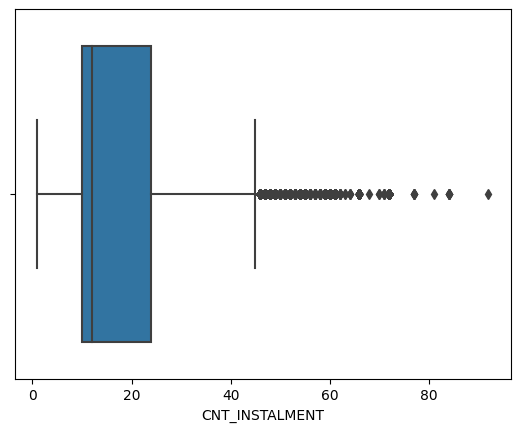

The feature CNT_INSTALMENT_FUTURE has the anomaly values:


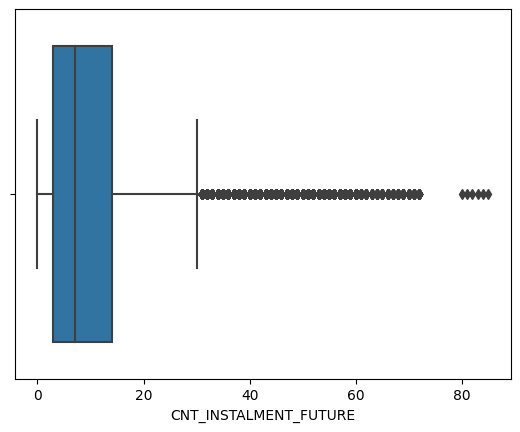

The feature SK_DPD has the anomaly values:


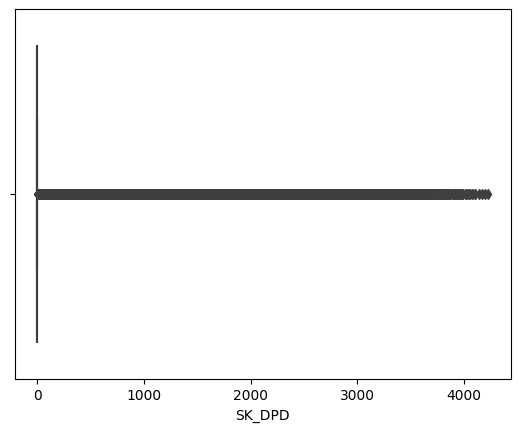

The feature SK_DPD_DEF has the anomaly values:


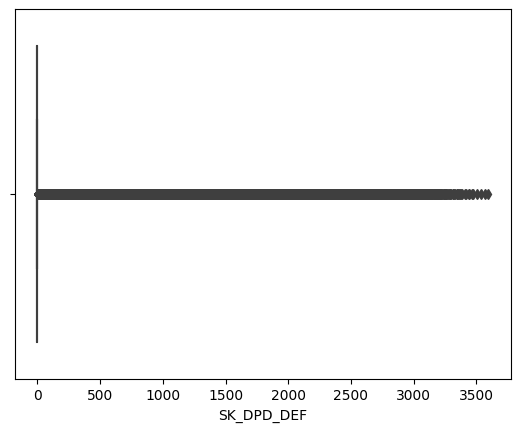

In [44]:
if analysis_mode:
  list_anomaly = check_potential_anomaly_values(df_pos_cash_balance, target='TARGET')

In [45]:
if analysis_mode:
  df_pos_cash_balance, label_encoders_pos = perform_label_encoding(df_pos_cash_balance)

perform_label_encoding: The following features has been transformed using LabelEncoder:
['NAME_CONTRACT_STATUS']


In [46]:
if analysis_mode:
  df_pos_cash_balance = reduce_data_size(df_pos_cash_balance)

Занимаемая память до оптимизации: 610.43 MB
Занимаемая память после оптимизации: 171.68 MB


In [47]:
if analysis_mode:
  del df_pos_cash_balance

### Функция предобработки

In [ ]:
def prepare_pos():
  ''' Подготовим данные из POS_CASH_balance.csv таблицы для использования

  Возвращаемые значения:
  pos_agg - данные из считанной таблицы с выполненной предобработкой
  '''
  # считываем данные
  df_pos_cash_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/POS_CASH_balance.csv')

  # заменяем аномальные значения
  df_pos_cash_balance = df_pos_cash_balance.replace('XNA', np.nan)

  # выполняем Label Encoding для категориальных признаков
  df_pos_cash_balance, label_encoders_pos = perform_label_encoding(df_pos_cash_balance)

  # уменьшаем занимаемую таблицей память
  df_pos_cash_balance = reduce_data_size(df_pos_cash_balance)

  pos_dict_agg = {'SK_ID_CURR': ['count'],
      'MONTHS_BALANCE': ['min', 'max', 'mean'],
      'CNT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
      'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'sum'],
      'SK_DPD': ['mean', 'sum'],
      'SK_DPD_DEF': ['mean', 'sum']
  }

  # группируем строки в таблице по SK_ID_CURR и аггрегируем значения
  # используя pos_dict_agg
  pos_agg = df_pos_cash_balance.groupby('SK_ID_CURR').agg(pos_dict_agg)
  pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
  return pos_agg

## credit_card_balance

In [48]:
if analysis_mode:
  df_credit_card_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/credit_card_balance.csv')

In [49]:
if analysis_mode:
  check_unique_object_type_values(df_credit_card_balance)

check_unique_object_type_values: Unique values for object type features:
NAME_CONTRACT_STATUS ['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']


In [50]:
if analysis_mode:
  print(get_missing_values_table(df_credit_card_balance))

                            count_missing_values  percentage_missing_values
AMT_PAYMENT_CURRENT                       767988                  19.998063
AMT_DRAWINGS_ATM_CURRENT                  749816                  19.524872
AMT_DRAWINGS_OTHER_CURRENT                749816                  19.524872
AMT_DRAWINGS_POS_CURRENT                  749816                  19.524872
CNT_DRAWINGS_ATM_CURRENT                  749816                  19.524872
CNT_DRAWINGS_OTHER_CURRENT                749816                  19.524872
CNT_DRAWINGS_POS_CURRENT                  749816                  19.524872
AMT_INST_MIN_REGULARITY                   305236                   7.948208
CNT_INSTALMENT_MATURE_CUM                 305236                   7.948208


The feature AMT_BALANCE has the anomaly values:


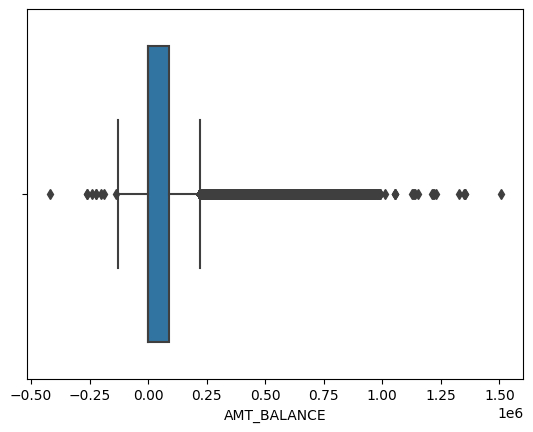

The feature AMT_CREDIT_LIMIT_ACTUAL has the anomaly values:


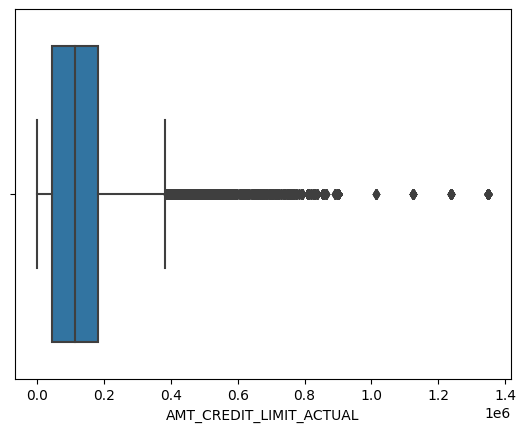

The feature AMT_DRAWINGS_ATM_CURRENT has the anomaly values:


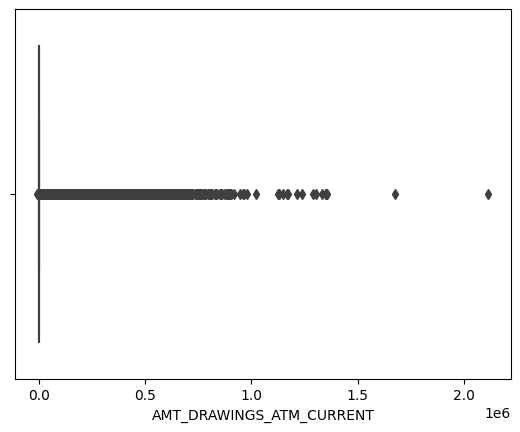

The feature AMT_DRAWINGS_CURRENT has the anomaly values:


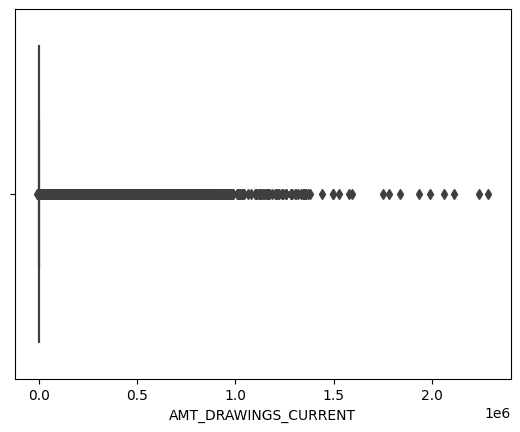

The feature AMT_DRAWINGS_OTHER_CURRENT has the anomaly values:


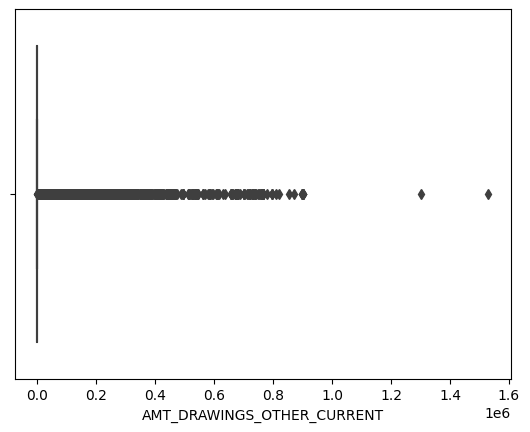

The feature AMT_DRAWINGS_POS_CURRENT has the anomaly values:


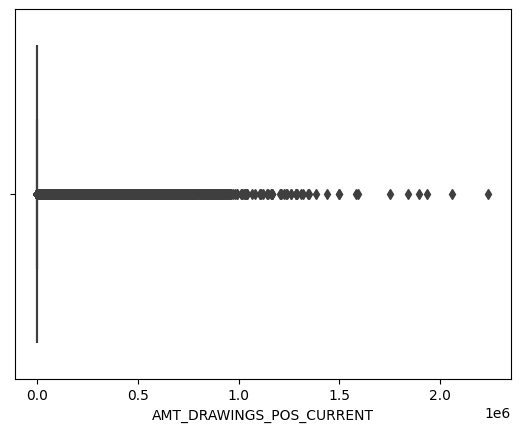

The feature AMT_INST_MIN_REGULARITY has the anomaly values:


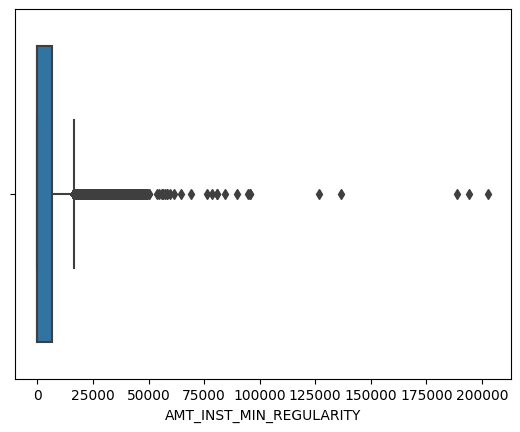

The feature AMT_PAYMENT_CURRENT has the anomaly values:


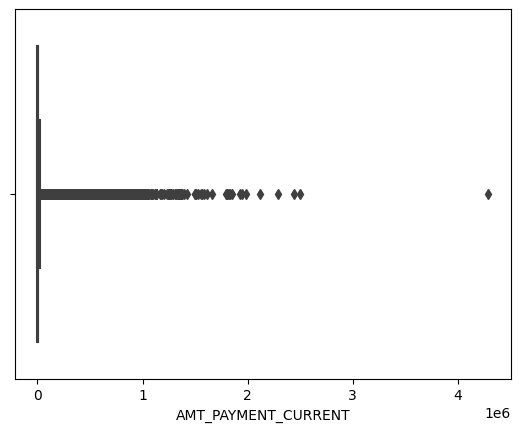

The feature AMT_PAYMENT_TOTAL_CURRENT has the anomaly values:


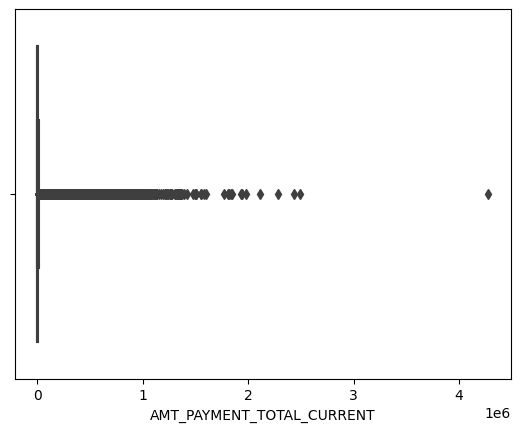

The feature AMT_RECEIVABLE_PRINCIPAL has the anomaly values:


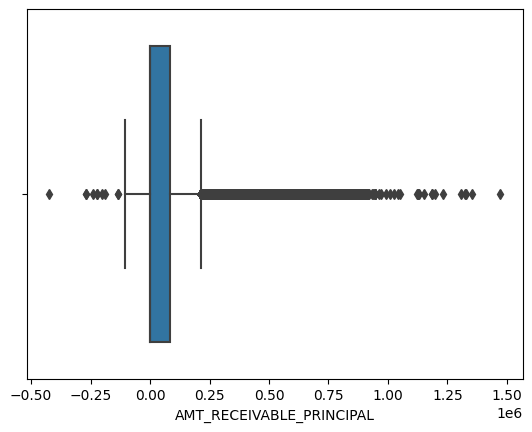

The feature AMT_RECIVABLE has the anomaly values:


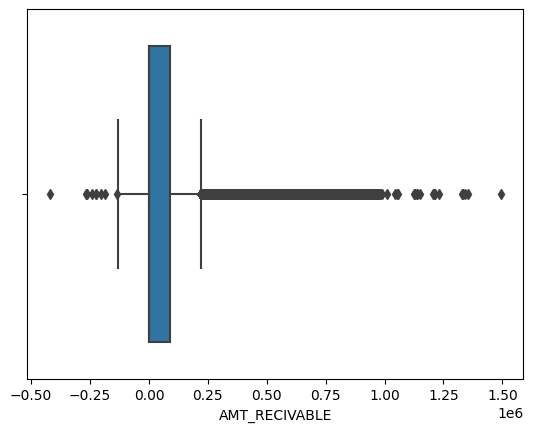

The feature AMT_TOTAL_RECEIVABLE has the anomaly values:


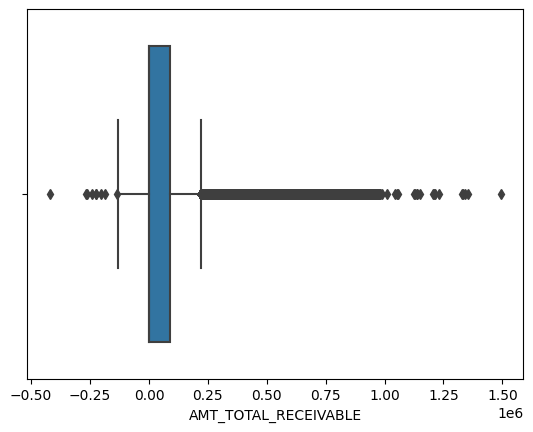

The feature CNT_DRAWINGS_ATM_CURRENT has the anomaly values:


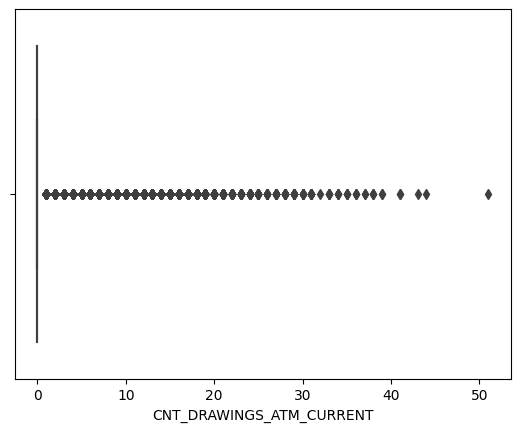

The feature CNT_DRAWINGS_CURRENT has the anomaly values:


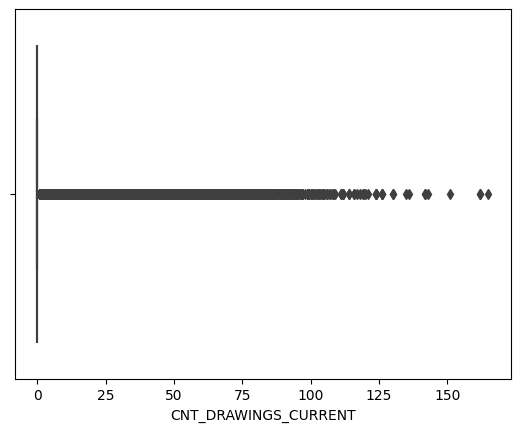

The feature CNT_DRAWINGS_OTHER_CURRENT has the anomaly values:


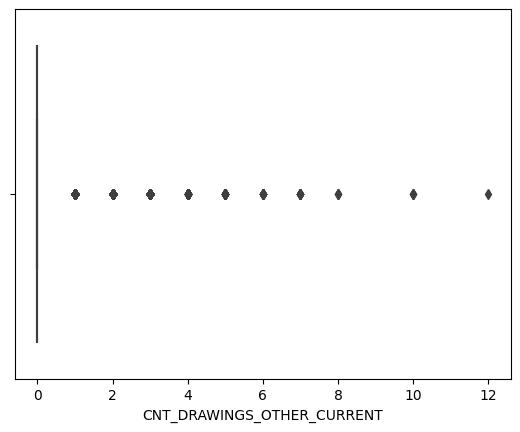

The feature CNT_DRAWINGS_POS_CURRENT has the anomaly values:


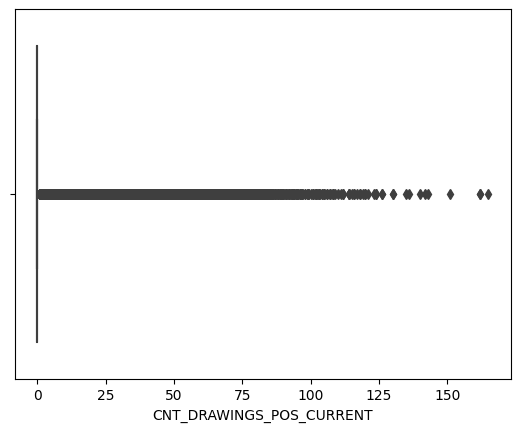

The feature CNT_INSTALMENT_MATURE_CUM has the anomaly values:


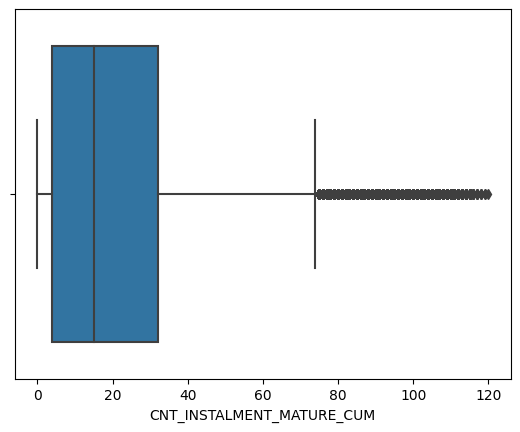

The feature SK_DPD has the anomaly values:


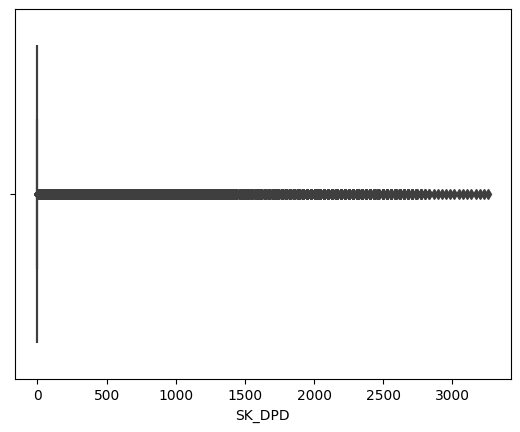

The feature SK_DPD_DEF has the anomaly values:


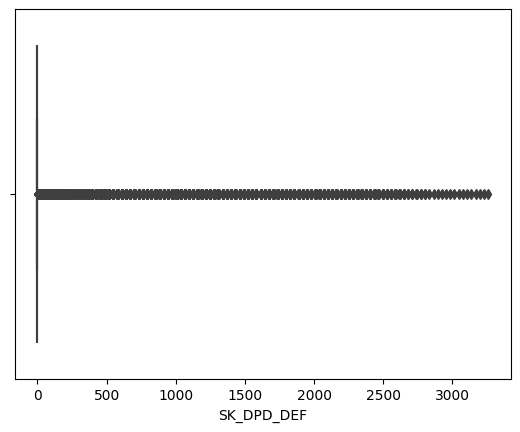

In [51]:
if analysis_mode:
  list_anomaly = check_potential_anomaly_values(df_credit_card_balance, target='TARGET')

In [52]:
if analysis_mode:
  df_credit_card_balance, label_encoders_credit = perform_label_encoding(df_credit_card_balance)

perform_label_encoding: The following features has been transformed using LabelEncoder:
['NAME_CONTRACT_STATUS']


In [53]:
if analysis_mode:
  df_credit_card_balance = reduce_data_size(df_credit_card_balance)

Занимаемая память до оптимизации: 673.88 MB
Занимаемая память после оптимизации: 263.69 MB


In [54]:
if analysis_mode:
  del df_credit_card_balance

### Функция предобработки

In [ ]:
def prepare_credit_card():
  ''' Подготовим данные из credit_card_balance.csv таблицы для использования

  Возвращаемые значения:
  credit_agg - данные из считанной таблицы с выполненной предобработкой
  '''
  # считываем данные
  df_credit_card_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Профильный модуль/final_proj/credit_card_balance.csv')

  # выполняем Label Encoding для категориальных признаков
  df_credit_card_balance, label_encoders_credit = perform_label_encoding(df_credit_card_balance)

  # уменьшаем занимаемую таблицей памят
  df_credit_card_balance = reduce_data_size(df_credit_card_balance)

  credit_dict_agg = {'SK_ID_CURR': ['count'],
      'MONTHS_BALANCE': ['min', 'max', 'mean'],
      'AMT_BALANCE': ['max'],
      'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
      'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
      'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
      'AMT_PAYMENT_CURRENT': ['max','sum'],
      'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
      'AMT_RECEIVABLE_PRINCIPAL': ['max','sum'],
      'AMT_RECIVABLE': ['max','sum'],
      'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
      'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_POS_CURRENT': ['mean'],
      'CNT_INSTALMENT_MATURE_CUM': ['max', 'mean', 'sum'],
      'SK_DPD': ['mean', 'sum'],
      'SK_DPD_DEF': ['mean', 'sum']    
  }

  # группируем строки в таблице по SK_ID_CURR и аггрегируем значения
  # используя credit_dict_agg
  credit_agg = df_credit_card_balance.groupby('SK_ID_CURR').agg(credit_dict_agg)
  credit_agg.columns = pd.Index(['CREDIT_' + e[0] + "_" + e[1].upper() for e in credit_agg.columns.tolist()])

  return credit_agg

# Searching Parameters

In [ ]:
if search_param_mode:
  df_train, df_test = prepare_application_train_test()
  df_bureau = prepare_bureau()
  df_previous_appl = prepare_previous_application()
  df_installments = prepare_installments()
  df_pos_cash = prepare_pos()
  df_credit_card = prepare_credit_card()

In [ ]:
if search_param_mode:
  df_train_target = df_train[['SK_ID_CURR', 'TARGET']]
  df_bureau_target = df_train_target.merge(df_bureau, how='left', on='SK_ID_CURR')
  df_previous_appl_target = df_train_target.merge(df_previous_appl, how='left', on='SK_ID_CURR')
  df_installments_target = df_train_target.merge(df_installments, how='left', on='SK_ID_CURR')
  df_pos_cash_target = df_train_target.merge(df_pos_cash, how='left', on='SK_ID_CURR')
  df_credit_card_target = df_train_target.merge(df_credit_card, how='left', on='SK_ID_CURR')

In [ ]:
if search_param_mode:
  X = df_train.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_train['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model_lightGBM_train, df_scores_lightGBM_train = search_best_params_LGBM(X_train, y_train, X_valid, y_valid)

In [ ]:
if search_param_mode:
  X = df_bureau_target.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_bureau_target['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model_lightGBM_b, df_scores_lightGBM_b = search_best_params_LGBM(X_train, y_train, X_valid, y_valid)

In [ ]:
if search_param_mode:
  X = df_previous_appl_target.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_previous_appl_target['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model_lightGBM_prev, df_scores_lightGBM_prev = search_best_params_LGBM(X_train, y_train, X_valid, y_valid)

In [ ]:
if search_param_mode:
  X = df_installments_target.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_installments_target['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model_lightGBM_inst, df_scores_lightGBM_inst = search_best_params_LGBM(X_train, y_train, X_valid, y_valid)

In [ ]:
if search_param_mode:
  X = df_pos_cash_target.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_pos_cash_target['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model_lightGBM_pos, df_scores_lightGBM_pos = search_best_params_LGBM(X_train, y_train, X_valid, y_valid)

In [ ]:
if search_param_mode:
  X = df_credit_card_target.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df_credit_card_target['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  model_lightGBM_card, df_scores_lightGBM_card = search_best_params_LGBM(X_train, y_train, X_valid, y_valid)

# Training

Обучим 6 моделей для каждого полученного датасета

Загрузим и предобработаем данные из таблиц

In [ ]:
if predict_mode:
  df_train, df_test = prepare_application_train_test()
  df_bureau = prepare_bureau()
  df_previous_appl = prepare_previous_application()
  df_installments = prepare_installments()
  df_pos_cash = prepare_pos()
  df_credit_card = prepare_credit_card()

perform_label_encoding: The following features has been transformed using LabelEncoder:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Занимаемая память до оптимизации: 286.23 MB
Занимаемая память после оптимизации: 58.95 MB
Занимаемая память до оптимизации: 45.00 MB
Занимаемая память после оптимизации: 9.30 MB
perform_label_encoding: The following features has been transformed using LabelEncoder:
['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'STATUS']
Занимаемая память до оптимизации: 3833.28 MB
Занимаемая память после оптимизации: 1413.52 MB
perform_label_encoding: The following features has been transformed using LabelEncoder:
['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_P

Отберем из дополнительных таблиц строки соответствующие SK_ID_CURR из application_train таблицы. Добавим отобранным строкам целевой признак из application_train таблицы

In [ ]:
if predict_mode:
  df_train_target = df_train[['SK_ID_CURR', 'TARGET']]
  df_bureau_target = df_train_target.merge(df_bureau, how='left', on='SK_ID_CURR')
  df_previous_appl_target = df_train_target.merge(df_previous_appl, how='left', on='SK_ID_CURR')
  df_installments_target = df_train_target.merge(df_installments, how='left', on='SK_ID_CURR')
  df_pos_cash_target = df_train_target.merge(df_pos_cash, how='left', on='SK_ID_CURR')
  df_credit_card_target = df_train_target.merge(df_credit_card, how='left', on='SK_ID_CURR')

In [ ]:
def fit_LGBM(df, name_table, model):
  ''' Обучает модель и выполняет предсказания

  Входные параметры:
  df - датасет
  name_table - имя таблицы для которой выполняется обучение
  model - модель для обучения

  Возвращаемые значения:
  model - обученная на входных данных
  result - предсказанные значения
  '''
  X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
  y = df['TARGET']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

  model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric= 'auc',
                callbacks=[lgb.log_evaluation(100), lgb.early_stopping(200)])

  show_confusion_matrix(model, X_valid, y_valid)
  roc_auc_appl = calculate_roc_auc(model, X_train, y_train, X_valid, y_valid)

  result = pd.DataFrame({'SK_ID_CURR': df.SK_ID_CURR, 'TARGET': df.TARGET, name_table: model.predict_proba(X)[:, 1]})

  return model, result

## application_train

In [ ]:
# feature_importances_domain = pd.DataFrame({'feature': list(df_train.drop(columns=['SK_ID_CURR', 'TARGET']).columns), 'importance': model_appl.feature_importances_})

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.770292	training's binary_logloss: 0.24281	valid_1's auc: 0.752429	valid_1's binary_logloss: 0.247113
[200]	training's auc: 0.784972	training's binary_logloss: 0.238329	valid_1's auc: 0.753215	valid_1's binary_logloss: 0.246639
[300]	training's auc: 0.796885	training's binary_logloss: 0.234534	valid_1's auc: 0.753735	valid_1's binary_logloss: 0.246501
[400]	training's auc: 0.807335	training's binary_logloss: 0.231081	valid_1's auc: 0.754055	valid_1's binary_logloss: 0.246486
[500]	training's auc: 0.816972	training's binary_logloss: 0.227828	valid_1's auc: 0.753578	valid_1's binary_logloss: 0.246591
Early stopping, best iteration is:
[327]	training's auc: 0.799633	training's binary_logloss: 0.233618	valid_1's auc: 0.754017	valid_1's binary_logloss: 0.246424


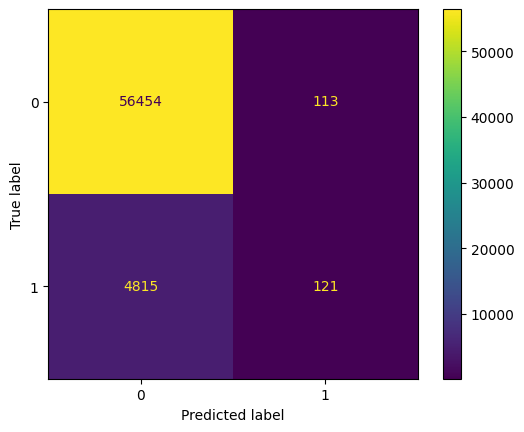

ROC-AUC
TRAIN:  -- 0.7996325102040978
VALID:  -- 0.7540167331870391


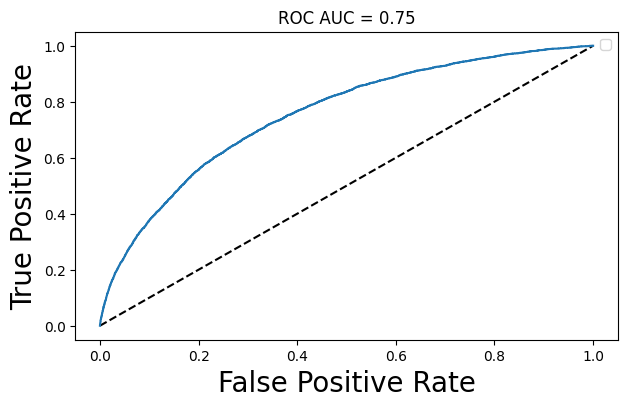

In [ ]:
if predict_mode:
  model_appl = lgb.LGBMClassifier(num_leaves=9,
                                n_estimators=1800,
                                max_depth=5,
                                max_bin=700,
                                learning_rate=0.1874949494949495,
                                reg_lambda=1.7223773773773772,
                                reg_alpha=3.688950950950951)
  model_appl, appl_result = fit_LGBM(df_train, 'application_train', model_appl)

## bureau

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.704712	training's binary_logloss: 0.260151	valid_1's auc: 0.649515	valid_1's binary_logloss: 0.268312
[200]	training's auc: 0.73479	training's binary_logloss: 0.25391	valid_1's auc: 0.648893	valid_1's binary_logloss: 0.268361
[300]	training's auc: 0.759766	training's binary_logloss: 0.248485	valid_1's auc: 0.648339	valid_1's binary_logloss: 0.268484
Early stopping, best iteration is:
[131]	training's auc: 0.714956	training's binary_logloss: 0.258044	valid_1's auc: 0.649365	valid_1's binary_logloss: 0.268238


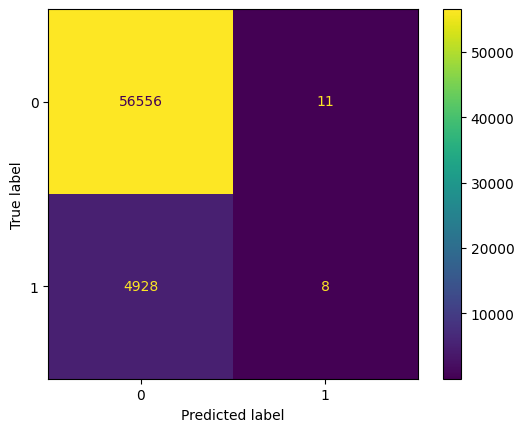

ROC-AUC
TRAIN:  -- 0.7149556587470813
VALID:  -- 0.6493647190052078


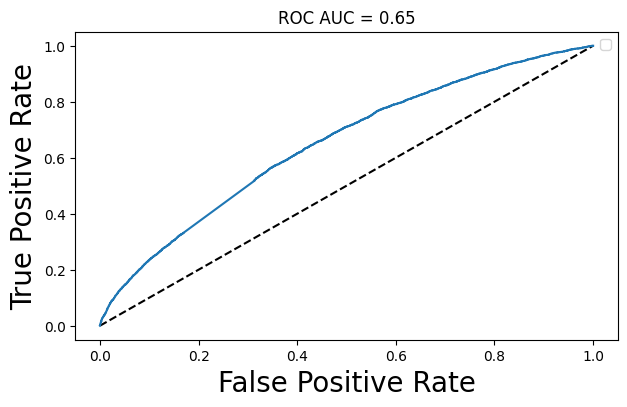

In [ ]:
if predict_mode:
  model_bureau = lgb.LGBMClassifier(num_leaves=56,
                                n_estimators=1800,
                                max_depth=17,
                                max_bin=820,
                                learning_rate=0.0514040404040404,
                                reg_lambda=3.558846846846847,
                                reg_alpha=1.8074454454454454)
  model_bureau, bureau_result = fit_LGBM(df_bureau_target, 'bureau', model_bureau)

## previous_application

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.711045	training's binary_logloss: 0.259698	valid_1's auc: 0.659304	valid_1's binary_logloss: 0.266861
[200]	training's auc: 0.747902	training's binary_logloss: 0.25245	valid_1's auc: 0.659498	valid_1's binary_logloss: 0.266706
[300]	training's auc: 0.775496	training's binary_logloss: 0.246353	valid_1's auc: 0.659712	valid_1's binary_logloss: 0.266744
[400]	training's auc: 0.800791	training's binary_logloss: 0.240482	valid_1's auc: 0.658812	valid_1's binary_logloss: 0.266921
Early stopping, best iteration is:
[240]	training's auc: 0.759903	training's binary_logloss: 0.249795	valid_1's auc: 0.659902	valid_1's binary_logloss: 0.266635


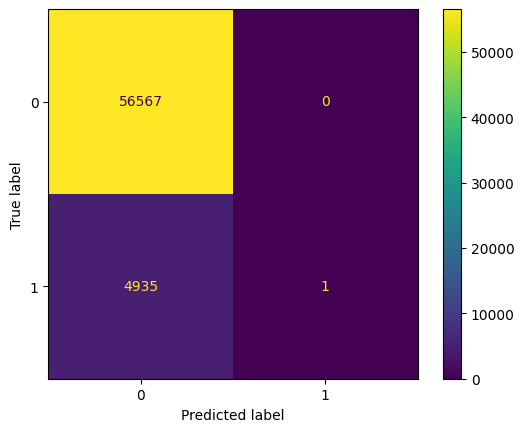

ROC-AUC
TRAIN:  -- 0.7599025635310837
VALID:  -- 0.6599017855477473


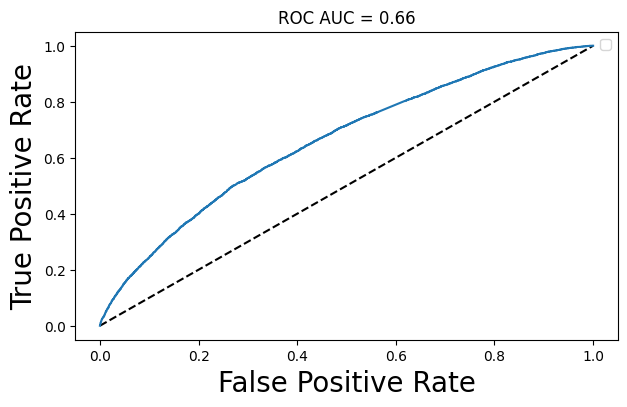

In [ ]:
if predict_mode:
  model_prev = lgb.LGBMClassifier(num_leaves=42,
                                n_estimators=2400,
                                max_depth=25,
                                max_bin=900,
                                learning_rate=0.06652525252525253,
                                reg_lambda=3.934147147147147,
                                reg_alpha=4.8048438438438446)
  model_prev, prev_result = fit_LGBM(df_previous_appl_target, 'previous_application', model_prev)

## installments_payments

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.686135	training's binary_logloss: 0.264794	valid_1's auc: 0.63054	valid_1's binary_logloss: 0.270932
[200]	training's auc: 0.719995	training's binary_logloss: 0.259211	valid_1's auc: 0.630025	valid_1's binary_logloss: 0.270958
[300]	training's auc: 0.745581	training's binary_logloss: 0.254452	valid_1's auc: 0.628336	valid_1's binary_logloss: 0.271253
Early stopping, best iteration is:
[115]	training's auc: 0.691778	training's binary_logloss: 0.263854	valid_1's auc: 0.630929	valid_1's binary_logloss: 0.270862


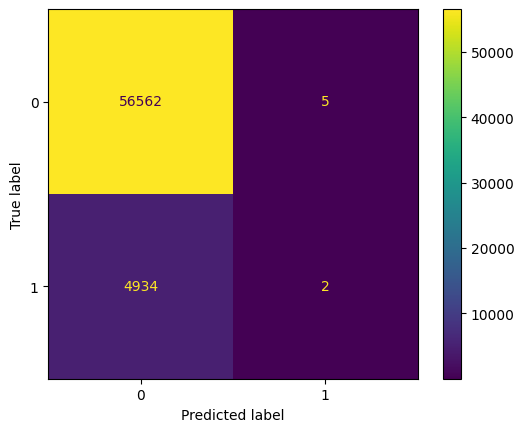

ROC-AUC
TRAIN:  -- 0.6917781581986172
VALID:  -- 0.6309289766221202


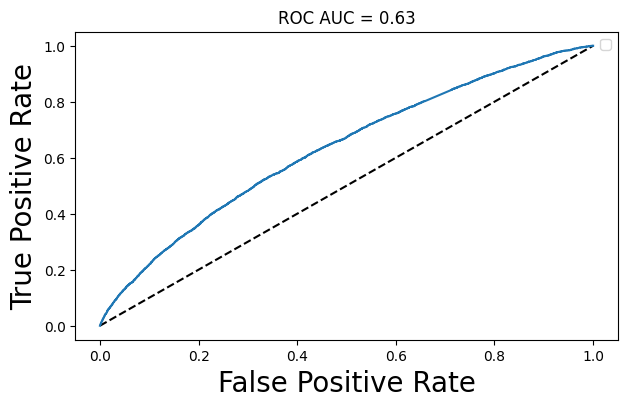

In [ ]:
if predict_mode:
  model_inst = lgb.LGBMClassifier(num_leaves=37,
                                n_estimators=1200,
                                max_depth=20,
                                max_bin=2200,
                                learning_rate=0.08164646464646465,
                                reg_lambda=2.0776616616616614,
                                reg_alpha=3.4037227227227227)
  model_ins, inst_result = fit_LGBM(df_installments_target, 'installments_payments', model_inst)

## POS_CASH_balance

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.630622	training's binary_logloss: 0.272153	valid_1's auc: 0.607875	valid_1's binary_logloss: 0.273447
[200]	training's auc: 0.646296	training's binary_logloss: 0.27008	valid_1's auc: 0.606845	valid_1's binary_logloss: 0.273484
[300]	training's auc: 0.659389	training's binary_logloss: 0.268321	valid_1's auc: 0.60582	valid_1's binary_logloss: 0.273611
Early stopping, best iteration is:
[100]	training's auc: 0.630622	training's binary_logloss: 0.272153	valid_1's auc: 0.607875	valid_1's binary_logloss: 0.273447


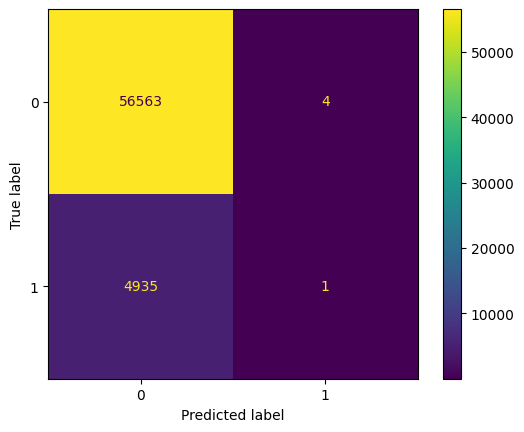

ROC-AUC
TRAIN:  -- 0.6306218689247949
VALID:  -- 0.6078747096965291


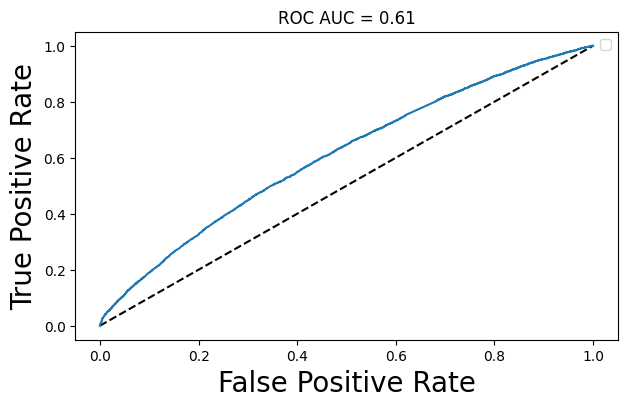

In [ ]:
if predict_mode:
  model_pos = lgb.LGBMClassifier(num_leaves=20,
                                n_estimators=4200,
                                max_depth=7,
                                max_bin=170,
                                learning_rate=0.08164646464646465,
                                reg_lambda=3.0834664664664664,
                                reg_alpha=4.389511511511512)
  model_pos, pos_result = fit_LGBM(df_pos_cash_target, 'pos_cash_balance', model_pos)

## credit_card_balance

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.588422	training's binary_logloss: 0.272486	valid_1's auc: 0.566044	valid_1's binary_logloss: 0.27511
[200]	training's auc: 0.602241	training's binary_logloss: 0.269633	valid_1's auc: 0.56384	valid_1's binary_logloss: 0.275282
Early stopping, best iteration is:
[43]	training's auc: 0.578351	training's binary_logloss: 0.274349	valid_1's auc: 0.567079	valid_1's binary_logloss: 0.275033


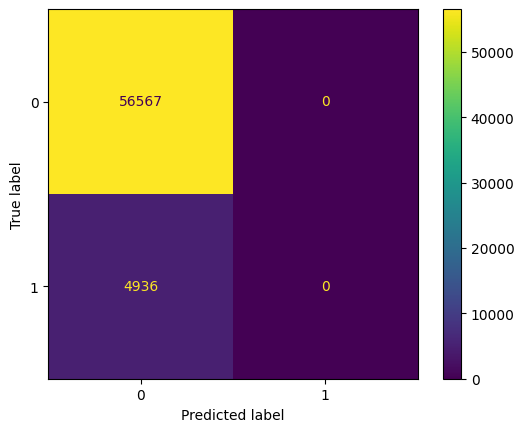

ROC-AUC
TRAIN:  -- 0.57835146855966
VALID:  -- 0.567079004776797


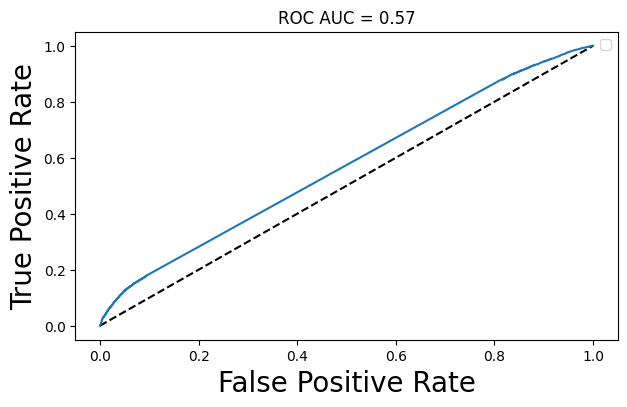

In [ ]:
if predict_mode:
  model_card = lgb.LGBMClassifier(num_leaves=18,
                                n_estimators=2400,
                                max_depth=5,
                                max_bin=600,
                                learning_rate=0.11692929292929292,
                                reg_lambda=3.4637707707707706,
                                reg_alpha=3.1034824824824825)
  model_card, card_result = fit_LGBM(df_credit_card_target, 'credit_card_balance', model_card)

# Взвешенное голосование

Соберем предсказанные обученными ранее 6 моделями значения в одну таблицу

In [ ]:
if predict_mode:
  result = appl_result.merge(bureau_result.drop(columns=['TARGET']), how='left', on='SK_ID_CURR')
  result = result.merge(prev_result.drop(columns=['TARGET']), how='left', on='SK_ID_CURR')
  result = result.merge(inst_result.drop(columns=['TARGET']), how='left', on='SK_ID_CURR')
  result = result.merge(pos_result.drop(columns=['TARGET']), how='left', on='SK_ID_CURR')
  result = result.merge(card_result.drop(columns=['TARGET']), how='left', on='SK_ID_CURR')
  result

In [ ]:
# набор весов, для которых проведем испытания
weights = [
    [0.2, 0.2, 0.2, 0.2, 0.1, 0.1],
    [0.2, 0.2, 0.2, 0.1, 0.2, 0.1],
    [0.2, 0.2, 0.2, 0.1, 0.1, 0.2],
    [0.2, 0.2, 0.2, 0.2, 0.1, 0.1],
    [0.3, 0.2, 0.2, 0.1, 0.1, 0.1],
    [0.3, 0.2, 0.1, 0.2, 0.1, 0.1],
    [0.3, 0.2, 0.1, 0.1, 0.2, 0.1],
    [0.3, 0.2, 0.1, 0.1, 0.1, 0.2],
    [0.3, 0.3, 0.1, 0.1, 0.1, 0.1],
    [0.3, 0.1, 0.3, 0.1, 0.1, 0.1],
    [0.3, 0.1, 0.1, 0.3, 0.1, 0.1],
    [0.3, 0.1, 0.1, 0.1, 0.3, 0.1],
    [0.3, 0.1, 0.1, 0.1, 0.1, 0.3],
    [0.4, 0.2, 0.1, 0.1, 0.1, 0.1],
    [0.4, 0.1, 0.2, 0.1, 0.1, 0.1],
    [0.4, 0.1, 0.1, 0.2, 0.1, 0.1],
    [0.4, 0.1, 0.1, 0.1, 0.2, 0.1],
    [0.4, 0.1, 0.1, 0.1, 0.1, 0.2],
    [0.5, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.6, 0.0, 0.1, 0.1, 0.1, 0.1],
    [0.6, 0.1, 0.0, 0.1, 0.1, 0.1],
    [0.6, 0.1, 0.1, 0.0, 0.1, 0.1],
    [0.6, 0.1, 0.1, 0.1, 0.0, 0.1],
    [0.6, 0.1, 0.1, 0.1, 0.1, 0.0],
    [1, 0, 0, 0, 0, 0]
]

In [ ]:
if predict_mode:
  X_res = result.drop(columns=['SK_ID_CURR', 'TARGET'])
  y_res = result['TARGET']

In [ ]:
if predict_mode:
  scores_train = []

  for w in weights:
    y_pred_train = w[0] * X_res.application_train + w[1] * X_res.bureau + \
        w[2] * X_res.previous_application + w[3] * X_res.installments_payments + \
        w[4] * X_res.pos_cash_balance + w[5] * X_res.credit_card_balance
    roc_auc_train = roc_auc_score(y_res, y_pred_train)
    scores_train.append(roc_auc_train)

In [ ]:
if predict_mode:
  score_table = pd.DataFrame({'weights': weights, 
                            'roc_auc_train': scores_train})
  print(score_table)

                           weights  roc_auc_train
0   [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]       0.822699
1   [0.2, 0.2, 0.2, 0.1, 0.2, 0.1]       0.822205
2   [0.2, 0.2, 0.2, 0.1, 0.1, 0.2]       0.823361
3   [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]       0.822699
4   [0.3, 0.2, 0.2, 0.1, 0.1, 0.1]       0.825875
5   [0.3, 0.2, 0.1, 0.2, 0.1, 0.1]       0.821897
6   [0.3, 0.2, 0.1, 0.1, 0.2, 0.1]       0.821095
7   [0.3, 0.2, 0.1, 0.1, 0.1, 0.2]       0.821644
8   [0.3, 0.3, 0.1, 0.1, 0.1, 0.1]       0.819932
9   [0.3, 0.1, 0.3, 0.1, 0.1, 0.1]       0.825441
10  [0.3, 0.1, 0.1, 0.3, 0.1, 0.1]       0.818593
11  [0.3, 0.1, 0.1, 0.1, 0.3, 0.1]       0.817360
12  [0.3, 0.1, 0.1, 0.1, 0.1, 0.3]       0.819708
13  [0.4, 0.2, 0.1, 0.1, 0.1, 0.1]       0.820850
14  [0.4, 0.1, 0.2, 0.1, 0.1, 0.1]       0.824019
15  [0.4, 0.1, 0.1, 0.2, 0.1, 0.1]       0.820201
16  [0.4, 0.1, 0.1, 0.1, 0.2, 0.1]       0.819367
17  [0.4, 0.1, 0.1, 0.1, 0.1, 0.2]       0.819761
18  [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]       0.817812


Наилучший результат наблюдается для весов [0.3, 0.2, 0.2, 0.1, 0.1, 0.1]

# Логистическая регрессия

In [ ]:
if predict_mode:
  X_res = result.drop(columns=['SK_ID_CURR', 'TARGET'])
  y_res = result['TARGET']
  X_train_res, X_valid_res, y_train_res, y_valid_res = train_test_split(X_res, y_res, test_size=0.2, random_state=13)

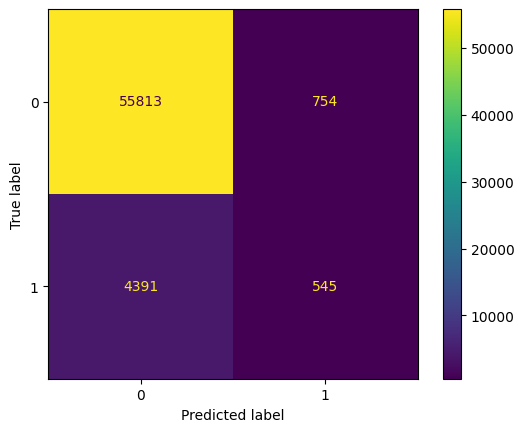

ROC-AUC
TRAIN:  -- 0.8403913637243915
VALID:  -- 0.7598321359226945


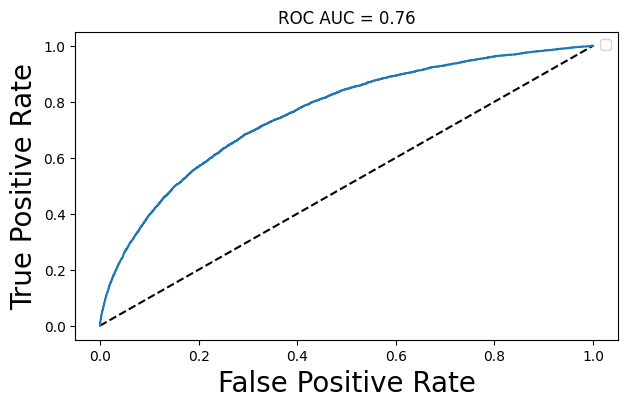

In [ ]:
if predict_mode:
  # создадим и обучим модель
  model_log, roc_auc_log_regr = fit_logistic_regression(X_train_res, y_train_res, X_valid_res, y_valid_res)

# LightGBM

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.853876	training's binary_logloss: 0.207837	valid_1's auc: 0.766438	valid_1's binary_logloss: 0.249076
[200]	training's auc: 0.85765	training's binary_logloss: 0.205771	valid_1's auc: 0.766129	valid_1's binary_logloss: 0.249757
Early stopping, best iteration is:
[14]	training's auc: 0.846027	training's binary_logloss: 0.215644	valid_1's auc: 0.764446	valid_1's binary_logloss: 0.244244


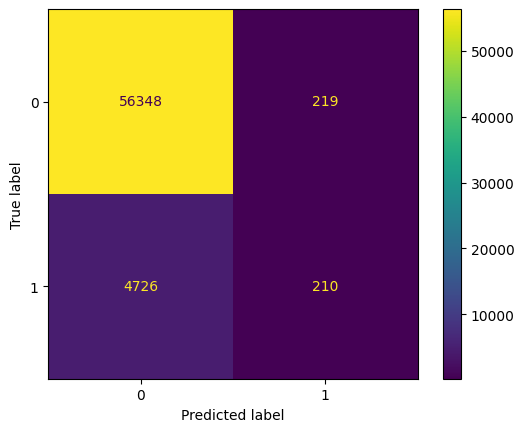

ROC-AUC
TRAIN:  -- 0.8460272708820507
VALID:  -- 0.764446226601412


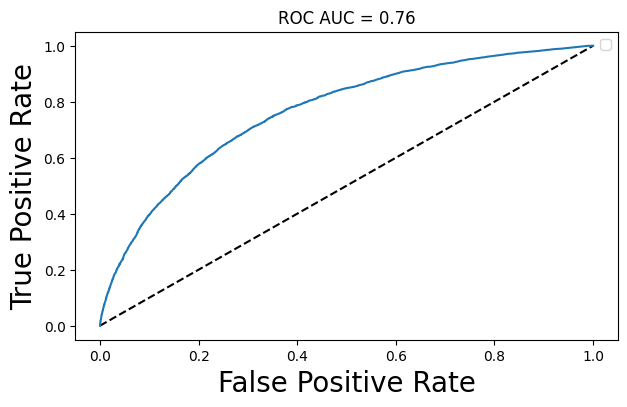

In [ ]:
if predict_mode:
  model_lgbm_mixing = lgb.LGBMClassifier(num_leaves=15,
                                n_estimators=1600,
                                max_depth=4,
                                max_bin=330,
                                learning_rate=0.1370909090909091,
                                reg_lambda=2.878302302302302,
                                reg_alpha=3.4287427427427426)
  model_lgbm_mixing, lgbm_mixing_result = fit_LGBM(result, 'mixing', model_lgbm_mixing)

# Prediction

Выполним предсказания, используя полученные модели

In [ ]:
weighted_voting = True
logistic_regr = False
lgbm = False

In [ ]:
def make_prediction(df_test, df, table_name, model):
  df_test = df_test.merge(df, how='left', on='SK_ID_CURR')
  X_test = df_test.drop(columns=['SK_ID_CURR'])
  test_result = pd.DataFrame({'SK_ID_CURR': df_test.SK_ID_CURR, table_name: model.predict_proba(X_test)[:, 1]})
  return test_result

In [ ]:
if predict_mode:
  X_test = df_test.drop(columns=['SK_ID_CURR'])
  test_appl_result = pd.DataFrame({'SK_ID_CURR': df_test.SK_ID_CURR, 'application_train': model_appl.predict_proba(X_test)[:, 1]})
  df_test_sk_id = df_test[['SK_ID_CURR']]

In [ ]:
if predict_mode:
  test_bureau_result = make_prediction(df_test_sk_id, df_bureau, 'bureau', model_bureau)
  test_prev_result = make_prediction(df_test_sk_id, df_previous_appl, 'previous_application', model_prev)
  test_inst_result = make_prediction(df_test_sk_id, df_installments, 'installments_payments', model_inst)
  test_pos_result = make_prediction(df_test_sk_id, df_pos_cash, 'pos_cash_balance', model_pos)
  test_card_result = make_prediction(df_test_sk_id, df_credit_card, 'credit_card_balance', model_card)

In [ ]:
if predict_mode:
  result_test = test_appl_result.merge(test_bureau_result, how='left', on='SK_ID_CURR')
  result_test = result_test.merge(test_prev_result, how='left', on='SK_ID_CURR')
  result_test = result_test.merge(test_inst_result, how='left', on='SK_ID_CURR')
  result_test = result_test.merge(test_pos_result, how='left', on='SK_ID_CURR')
  result_test = result_test.merge(test_card_result, how='left', on='SK_ID_CURR')

In [ ]:
if predict_mode and weighted_voting:
  w = [0.3, 0.2, 0.2, 0.1, 0.1, 0.1]
  y_pred_test = w[0] * result_test.application_train + w[1] * result_test.bureau + w[2] * result_test.previous_application + \
      w[3] * result_test.installments_payments + \
      w[4] * result_test.pos_cash_balance + w[5] * result_test.credit_card_balance

In [ ]:
if predict_mode and logistic_regr:
    y_pred_test = model_log.predict_proba(result_test.drop(columns=['SK_ID_CURR']))[:, 1]

In [ ]:
if predict_mode and lgbm:
    y_pred_test = model_lgbm_mixing.predict_proba(result_test.drop(columns=['SK_ID_CURR']))[:, 1]